# Imports

In [2637]:
import os
import time
import datetime
from dotenv import load_dotenv
import requests_cache

## data analysis
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

## scitkit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, get_scorer_names, classification_report, silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors

## statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## pandas-datareader
import pandas_datareader.data as web

## backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False) # might need this due to UserWarning

# Configuration Settings

In [2638]:
## configuration setup
load_dotenv()

# API request parameters
expire_after = datetime.timedelta(days=7) # cache requests expiry date
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

# model training parameters
USE_CLOSE_PRICE = False
TRAIN_PROPORTION = 0.7 # size of the dataset to use for training. (1 - TRAIN_PROPORTION) will be used for testing.

# Load Historical Data

In [2639]:
data = pd.read_csv("./data/XBTUSD_1440.csv", names=["Time","Open","High","Low","Close","Volume","Transactions"], header=None)
ticker = 'BTC-USD'

## Data Preparation

In [2640]:
# convert UNIX time to datetime
data['Time'] = pd.to_datetime(data['Time'], unit='s')

### Check that UNIX time has been converted to a readable datetime

In [2641]:
data.head(10)

,Time,Open,High,Low,Close,Volume,Transactions
0,2013-10-06,122.00000,122.00000,122.00000,122.00000,0.100000,1
1,2013-10-07,123.61000,123.61000,123.61000,123.61000,0.100000,1
2,2013-10-08,123.91000,124.19000,123.90000,124.18000,3.991600,4
3,2013-10-09,124.01687,124.01687,123.84000,123.84000,2.823000,3
4,2013-10-10,125.85000,125.86000,125.85000,125.86000,2.000000,2
5,2013-10-12,127.50000,127.50000,127.00000,127.00000,4.000000,3
6,2013-10-13,131.84080,131.84080,131.84080,131.84080,0.100000,1
7,2013-10-14,134.80000,135.59000,133.36726,135.59000,12.005753,11
8,2013-10-15,135.80000,153.00000,133.87975,133.87975,4.300000,5
9,2013-10-16,143.00000,146.14000,137.63758,138.09000,20.229000,17


### Set index of DataFrame to `time`

In [2642]:
data = data.set_index('Time')
data

,Open,High,Low,Close,Volume,Transactions
Time,,,,,,
2013-10-06,122.00000,122.00000,122.00,122.00,0.100000,1
2013-10-07,123.61000,123.61000,123.61,123.61,0.100000,1
2013-10-08,123.91000,124.19000,123.90,124.18,3.991600,4
2013-10-09,124.01687,124.01687,123.84,123.84,2.823000,3
2013-10-10,125.85000,125.86000,125.85,125.86,2.000000,2
...,...,...,...,...,...,...
2022-06-26,21476.80000,21867.00000,20957.00,21023.30,1913.190977,20649
2022-06-27,21023.40000,21528.70000,20505.50,20716.30,3973.836377,22966
2022-06-28,20716.30000,21188.50000,20165.30,20251.60,3250.533589,23648


### Start and End Dates

In [2643]:
start_date = data.head(1).index.item()
end_date = data.tail(1).index.item()
print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  2013-10-06 00:00:00
End date:  2022-06-30 00:00:00


In [2644]:
idx = pd.date_range(start_date, end_date)
data = data.reindex(idx)

In [2645]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Transactions']:
    data[col].ffill(inplace=True)

In [2646]:
pd.date_range(start = start_date, end = end_date ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [2647]:
data.head(10)

,Open,High,Low,Close,Volume,Transactions
2013-10-06,122.00000,122.00000,122.00000,122.00000,0.100000,1.0
2013-10-07,123.61000,123.61000,123.61000,123.61000,0.100000,1.0
2013-10-08,123.91000,124.19000,123.90000,124.18000,3.991600,4.0
2013-10-09,124.01687,124.01687,123.84000,123.84000,2.823000,3.0
2013-10-10,125.85000,125.86000,125.85000,125.86000,2.000000,2.0
2013-10-11,125.85000,125.86000,125.85000,125.86000,2.000000,2.0
2013-10-12,127.50000,127.50000,127.00000,127.00000,4.000000,3.0
2013-10-13,131.84080,131.84080,131.84080,131.84080,0.100000,1.0
2013-10-14,134.80000,135.59000,133.36726,135.59000,12.005753,11.0
2013-10-15,135.80000,153.00000,133.87975,133.87975,4.300000,5.0


### Rename columns to X_BTCUSD_[O/H/L/C/V]

In [2648]:
data.rename(columns = {'Open':'X_BTCUSD_Open', 
                       'High':'X_BTCUSD_High',
                       'Low':'X_BTCUSD_Low',
                       'Close':'X_BTCUSD_Close',
                       'Volume':'X_BTCUSD_Volume',
                       'Transactions':'X_BTCUSD_Transactions'}, inplace = True)
data

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,X_BTCUSD_Transactions
2013-10-06,122.00000,122.00000,122.00,122.00,0.100000,1.0
2013-10-07,123.61000,123.61000,123.61,123.61,0.100000,1.0
2013-10-08,123.91000,124.19000,123.90,124.18,3.991600,4.0
2013-10-09,124.01687,124.01687,123.84,123.84,2.823000,3.0
2013-10-10,125.85000,125.86000,125.85,125.86,2.000000,2.0
...,...,...,...,...,...,...
2022-06-26,21476.80000,21867.00000,20957.00,21023.30,1913.190977,20649.0
2022-06-27,21023.40000,21528.70000,20505.50,20716.30,3973.836377,22966.0
2022-06-28,20716.30000,21188.50000,20165.30,20251.60,3250.533589,23648.0
2022-06-29,20252.50000,20397.00000,19828.70,20086.20,4367.319083,26340.0


## Collect data from other sources

### Obtain Standard and Poor's 500 (S&P 500) Index Historical OHLCV

In [2649]:
df_spx = web.DataReader('^SPX', 'stooq', start=start_date, end=end_date, session=session)
df_spx = df_spx.iloc[::-1]
s = df_spx.head(1).index.item()
e = df_spx.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_spx.index = pd.DatetimeIndex(df_spx.index)
idx = pd.date_range(s, e)
df_spx = df_spx.reindex(idx)
for col in df_spx.columns:
    df_spx[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_spx.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("SPX DataFrame:")
df_spx = df_spx.pct_change()
df_spx

Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

SPX DataFrame:


,Open,High,Low,Close,Volume
2013-10-07,NaN,NaN,NaN,NaN,NaN
2013-10-08,-0.006478,-0.006141,-0.011745,-0.012332,0.332553
2013-10-09,-0.011472,-0.008540,-0.005172,0.000574,0.002412
2013-10-10,0.002348,0.018100,0.008752,0.021830,-0.060243
2013-10-11,0.018189,0.006428,0.016642,0.006286,-0.124210
...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.025907,0.003595,0.017769,-0.002973,-0.388761
2022-06-28,-0.001979,0.004618,-0.017873,-0.020143,0.057840
2022-06-29,-0.022466,-0.027715,-0.005529,-0.000712,-0.059852


### Obtain Dow Jones Industrial (DJI) Index Historical OHLCV

In [2650]:
df_dji = web.DataReader('^DJI', 'stooq', start=start_date, end=end_date, session=session)
df_dji = df_dji.iloc[::-1]
s = df_dji.head(1).index.item()
e = df_dji.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_dji.index = pd.DatetimeIndex(df_dji.index)
idx = pd.date_range(s, e)
df_dji = df_dji.reindex(idx)
for col in df_dji.columns:
    df_dji[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_dji.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("DJI DataFrame:")
df_dji = df_dji.pct_change()
df_dji

Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

DJI DataFrame:


,Open,High,Low,Close,Volume
2013-10-07,NaN,NaN,NaN,NaN,NaN
2013-10-08,-0.008710,-0.008710,-0.009876,-0.010693,0.289666
2013-10-09,-0.010701,-0.005726,-0.003658,0.001790,0.004624
2013-10-10,0.001908,0.018419,0.005908,0.021826,0.032810
2013-10-11,0.021621,0.007354,0.019839,0.007341,-0.195315
...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.022260,0.002580,0.016353,-0.001982,-0.316268
2022-06-28,0.000490,0.009067,-0.013302,-0.015627,0.135705
2022-06-29,-0.015266,-0.022962,-0.001287,0.002660,-0.226376


### Obtain Nasdaq Composite (NDQ) Index Historical OHLCV

In [2651]:
df_ndq = web.DataReader('^NDQ', 'stooq', start=start_date, end=end_date, session=session)
df_ndq = df_ndq.iloc[::-1]
s = df_ndq.head(1).index.item()
e = df_ndq.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_ndq.index = pd.DatetimeIndex(df_ndq.index)
idx = pd.date_range(s, e)
df_ndq = df_ndq.reindex(idx)
for col in df_ndq.columns:
    df_ndq[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_ndq.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("NDQ DataFrame:")
df_ndq = df_ndq.pct_change()
df_ndq

Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

NDQ DataFrame:


,Open,High,Low,Close,Volume
2013-10-07,NaN,NaN,NaN,NaN,NaN
2013-10-08,-0.001170,-0.007260,-0.020054,-0.020038,0.414359
2013-10-09,-0.018716,-0.018646,-0.011943,-0.004615,0.074306
2013-10-10,0.005392,0.016901,0.019474,0.022560,-0.151732
2013-10-11,0.008502,0.007876,0.008135,0.008275,-0.079930
...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.027284,0.005532,0.013167,-0.007157,-0.446036
2022-06-28,-0.010185,-0.003564,-0.026934,-0.029763,0.203235
2022-06-29,-0.033098,-0.035196,-0.009438,-0.000326,0.028774


### Obtain Shanghai Stock Exchange (SSE) Index Historical OHLCV

In [2652]:
df_shc = web.DataReader('^SHC', 'stooq', start=start_date, end=end_date, session=session)
df_shc = df_shc.iloc[::-1]
s = df_shc.head(1).index.item()
e = df_shc.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_shc.index = pd.DatetimeIndex(df_shc.index)
idx = pd.date_range(s, e)
df_shc = df_shc.reindex(idx)
for col in df_shc.columns:
    df_shc[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_shc.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("SSE DataFrame:")
df_shc = df_shc.pct_change()
df_shc

Start date:  2013-10-08 00:00:00
End date:  2022-06-30 00:00:00

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

SSE DataFrame:


,Open,High,Low,Close,Volume
2013-10-08,NaN,NaN,NaN,NaN,NaN
2013-10-09,0.008974,0.005604,0.010960,0.006173,NaN
2013-10-10,0.010505,0.001012,0.000595,-0.009422,NaN
2013-10-11,-0.005871,0.006448,0.006426,0.016988,NaN
2013-10-12,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.011811,0.010902,0.012355,0.008788,0.059613
2022-06-28,0.004065,0.005538,-0.001527,0.008885,-0.004977
2022-06-29,0.006513,0.000746,-0.000119,-0.013989,0.069207


### Obtain Financial Times Stock Exchange 100 (FTSE 100) Index Historical OHLCV

In [2653]:
df_ukx = web.DataReader('^UKX', 'stooq', start=start_date, end=end_date, session=session)
df_ukx = df_ukx.iloc[::-1]
s = df_ukx.head(1).index.item()
e = df_ukx.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_ukx.index = pd.DatetimeIndex(df_ukx.index)
idx = pd.date_range(s, e)
df_ukx = df_ukx.reindex(idx)
for col in df_ukx.columns:
    df_ukx[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_ukx.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("FTSE 100 DataFrame:")
df_ukx = df_ukx.pct_change()
df_ukx

Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

FTSE 100 DataFrame:


,Open,High,Low,Close,Volume
2013-10-07,NaN,NaN,NaN,NaN,NaN
2013-10-08,-0.002572,-0.002502,-0.004146,-0.011099,0.366594
2013-10-09,-0.011099,-0.010112,-0.007551,-0.004386,-0.077839
2013-10-10,-0.004386,0.011548,0.003324,0.014607,-0.024983
2013-10-11,0.014607,0.006661,0.014604,0.008817,-0.075439
...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.026830,0.010180,0.027437,0.006868,0.057717
2022-06-28,0.006868,0.010693,0.006908,0.008968,0.006103
2022-06-29,0.008968,-0.002298,0.000719,-0.001514,-0.141478


### Obtain USD/GBP Exchange Rate OHLC

In [2654]:
# ["USD/GBP", "USD/CNY", "USD/JPY", "USD/EUR", "USD/CHF"]
df_usdgbp = web.DataReader("USD/GBP", 
                   "av-forex-daily", 
                   start=start_date, 
                   end=end_date,
                   session=session,
                   api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
s = df_usdgbp.head(1).index.item()
e = df_usdgbp.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_usdgbp.index = pd.DatetimeIndex(df_usdgbp.index)
idx = pd.date_range(s, e)
df_usdgbp = df_usdgbp.reindex(idx)
for col in df_usdgbp.columns:
    df_usdgbp[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_usdgbp.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("USD/GBP DataFrame:")
df_usdgbp = df_usdgbp.pct_change()
df_usdgbp

Start date:  2014-11-24
End date:  2022-06-30

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

USD/GBP DataFrame:


,open,high,low,close
2014-11-24,NaN,NaN,NaN,NaN
2014-11-25,-0.003288,-0.001251,-0.001258,-0.000314
2014-11-26,-0.000314,-0.001879,-0.004565,-0.005657
2014-11-27,-0.005500,-0.002353,-0.001107,0.004741
2014-11-28,0.004582,0.006604,0.006016,0.004718
...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000
2022-06-27,-0.001201,0.000208,-0.001010,0.000025
2022-06-28,0.000258,0.004859,0.003144,0.007006
2022-06-29,0.007044,0.006298,0.006563,0.005069


### Obtain USD/CNY Exchange Rate OHLC

In [2655]:
df_usdcny = web.DataReader("USD/CNY", 
                   "av-forex-daily", 
                   start=start_date, 
                   end=end_date,
                   session=session,
                   api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
s = df_usdcny.head(1).index.item()
e = df_usdcny.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_usdcny.index = pd.DatetimeIndex(df_usdcny.index)
idx = pd.date_range(s, e)
df_usdcny = df_usdcny.reindex(idx)
for col in df_usdcny.columns:
    df_usdcny[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_usdcny.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("USD/CNY DataFrame:")
df_usdcny = df_usdcny.pct_change()
df_usdcny

Start date:  2013-10-08
End date:  2022-06-30

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

USD/CNY DataFrame:


,open,high,low,close
2013-10-08,NaN,NaN,NaN,NaN
2013-10-09,-0.000163,-0.000065,0.000163,0.000000
2013-10-10,0.000016,-0.000049,-0.000556,-0.000866
2013-10-11,-0.001111,-0.000033,-0.000654,0.000785
2013-10-12,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000
2022-06-27,-0.001404,-0.000866,0.000150,0.000239
2022-06-28,0.002289,0.002809,-0.001302,0.002631
2022-06-29,0.000821,-0.000477,0.001678,-0.001088


### Obtain USD/JPY Exchange Rate OHLC

In [2656]:
df_usdjpy = web.DataReader("USD/JPY", 
                   "av-forex-daily", 
                   start=start_date, 
                   end=end_date,
                   session=session,
                   api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
s = df_usdjpy.head(1).index.item()
e = df_usdjpy.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_usdjpy.index = pd.DatetimeIndex(df_usdjpy.index)
idx = pd.date_range(s, e)
df_usdjpy = df_usdjpy.reindex(idx)
for col in df_usdjpy.columns:
    df_usdjpy[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_usdjpy.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("USD/JPY DataFrame:")
df_usdjpy = df_usdjpy.pct_change()
df_usdjpy

Start date:  2013-10-07
End date:  2022-06-30

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

USD/JPY DataFrame:


,open,high,low,close
2013-10-07,NaN,NaN,NaN,NaN
2013-10-08,-0.006064,-0.000822,0.000104,0.001965
2013-10-09,0.001965,0.003805,0.002277,0.005058
2013-10-10,0.004954,0.007172,0.005474,0.009346
2013-10-11,0.009551,0.002848,0.005958,0.003053
...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000
2022-06-27,0.001757,0.001115,0.001191,0.001960
2022-06-28,0.001901,0.006145,0.004387,0.005073
2022-06-29,0.005221,0.004539,0.005034,0.003027


### Obtain USD/EUR Exchange Rate OHLC

In [2657]:
df_usdeur = web.DataReader("USD/EUR", 
                   "av-forex-daily", 
                   start=start_date, 
                   end=end_date,
                   session=session,
                   api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
s = df_usdeur.head(1).index.item()
e = df_usdeur.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_usdeur.index = pd.DatetimeIndex(df_usdeur.index)
idx = pd.date_range(s, e)
df_usdeur = df_usdeur.reindex(idx)
for col in df_usdeur.columns:
    df_usdeur[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_usdeur.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("USD/EUR DataFrame:")
df_usdeur = df_usdeur.pct_change()
df_usdeur

Start date:  2014-11-24
End date:  2022-06-30

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

USD/EUR DataFrame:


,open,high,low,close
2014-11-24,NaN,NaN,NaN,NaN
2014-11-25,-0.005445,-0.003216,-0.003113,-0.002738
2014-11-26,-0.002862,-0.003102,-0.003372,-0.002620
2014-11-27,-0.002620,-0.001245,0.000376,0.003628
2014-11-28,0.003753,0.002493,0.002631,0.000748
...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000
2022-06-27,-0.003263,-0.003470,-0.004334,-0.002640
2022-06-28,-0.002640,0.004432,0.000956,0.005823
2022-06-29,0.005929,0.006514,0.006471,0.007789


### Obtain USD/CHF Exchange Rate OHLC

In [2658]:
df_usdchf = web.DataReader("USD/CHF", 
                   "av-forex-daily", 
                   start=start_date, 
                   end=end_date,
                   session=session,
                   api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
s = df_usdchf.head(1).index.item()
e = df_usdchf.tail(1).index.item()
print("Start date: ", s)
print("End date: ", e)
df_usdchf.index = pd.DatetimeIndex(df_usdchf.index)
idx = pd.date_range(s, e)
df_usdchf = df_usdchf.reindex(idx)
for col in df_usdchf.columns:
    df_usdchf[col].ffill(inplace=True)
print("\nDates Missing: ")
print(pd.date_range(start = s, end = e).difference(df_usdchf.index),"\n")
print("Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue \n")
print("USD/CHF DataFrame:")
df_usdchf = df_usdchf.pct_change()
df_usdchf

Start date:  2013-10-07
End date:  2022-06-30

Dates Missing: 
DatetimeIndex([], dtype='datetime64[ns]', freq='D') 

Note: DatetimeIndex above should be an empty list, otherwise reindexing and forward filling has an issue 

USD/CHF DataFrame:


,open,high,low,close
2013-10-07,NaN,NaN,NaN,NaN
2013-10-08,-0.003640,-0.000221,0.000776,0.000664
2013-10-09,0.000886,0.006731,-0.000887,0.006749
2013-10-10,0.006748,0.000658,0.008209,0.001099
2013-10-11,0.001209,0.000000,-0.002200,0.000988
...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,0.000000
2022-06-27,-0.003090,-0.001277,0.002207,-0.001066
2022-06-28,-0.002317,-0.003461,-0.000629,0.000774
2022-06-29,0.001088,-0.000918,-0.004092,-0.002613


# Exploratory Data Analysis

In [2659]:
data.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,X_BTCUSD_Transactions
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,11116.257218,11436.532218,10744.319945,11122.421169,3694.235090,15680.015674
std,16092.886911,16535.436735,15560.020682,16092.735958,4176.330554,20056.380029
min,122.000000,122.000000,122.000000,122.000000,0.000038,1.000000
25%,576.759750,589.027118,565.348500,576.267250,190.654543,409.000000
50%,4655.450000,4876.500000,4456.923000,4698.635000,2722.498758,9810.500000
75%,10578.400000,10874.675000,10217.800000,10582.650000,5331.338755,23567.500000
max,67550.800000,68991.000000,66316.000000,67559.800000,45110.873425,238569.000000


## Graph of BTC-USD price over time

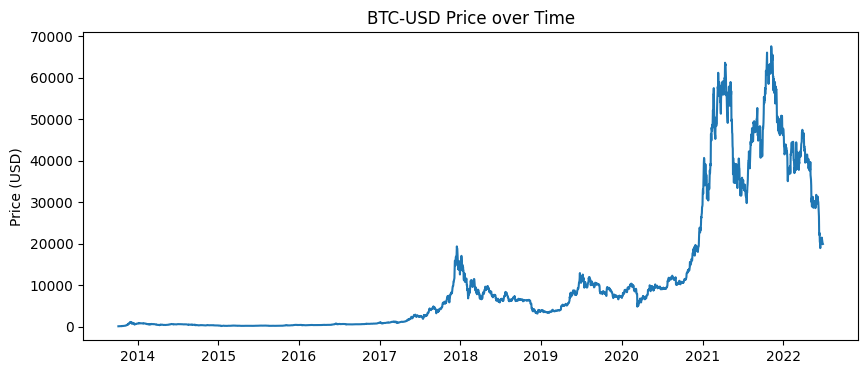

In [2660]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close)
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.savefig('btcusd__over_time.png')

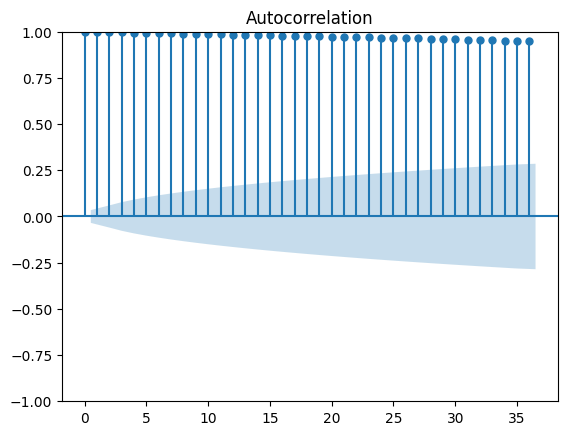

In [2661]:
acf_plot = plot_acf(data.X_BTCUSD_Close)
acf_plot.savefig('btcusd_acf.png')

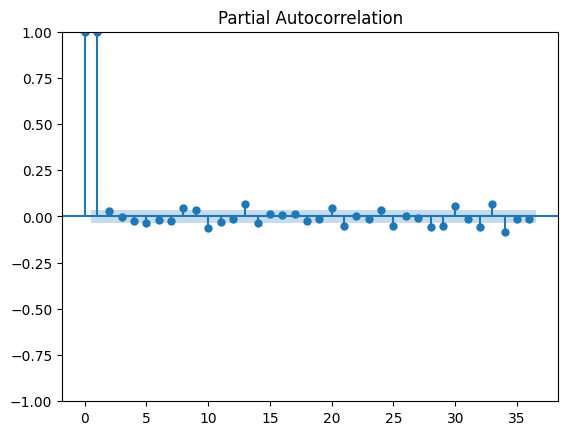

In [2662]:
pacf_plot = plot_pacf(data.X_BTCUSD_Close, method='ywm')
pacf_plot.savefig('btcusd_pacf.png')

## Look at first difference close price data

In [2663]:
# first differences
first_diffs = data.X_BTCUSD_Close.values[1:] - data.X_BTCUSD_Close.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])
df_first_diffs = data.assign(FirstDifference=first_diffs)

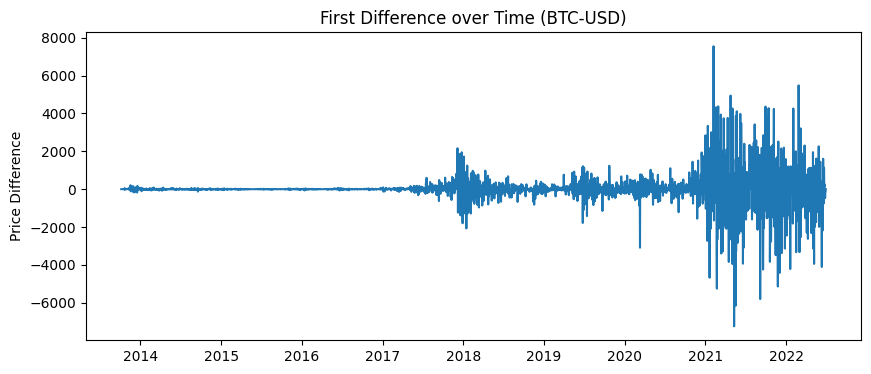

In [2664]:
# plot first differences
plt.figure(figsize=(10,4))
plt.plot(df_first_diffs.FirstDifference)
plt.title('First Difference over Time (%s)'%ticker)
plt.ylabel('Price Difference')
plt.savefig('btcusd_first_diff.png')

In [2665]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.X_BTCUSD_Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

result = adfuller(df_first_diffs.FirstDifference)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.10f' % result[1])

result = adfuller(df_returns.X_BTCUSD_Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.10f' % result[1])

ADF Test Statistic: -1.59
5% Critical Value: -2.86
p-value: 0.49
ADF Test Statistic: -9.31
5% Critical Value: -2.86
p-value: 0.0000000000
ADF Test Statistic: -14.42
5% Critical Value: -2.86
p-value: 0.0000000000


In [2666]:
df_first_diffs.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,X_BTCUSD_Transactions,FirstDifference
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,11116.257218,11436.532218,10744.319945,11122.421169,3694.235090,15680.015674,6.215643
std,16092.886911,16535.436735,15560.020682,16092.735958,4176.330554,20056.380029,765.966214
min,122.000000,122.000000,122.000000,122.000000,0.000038,1.000000,-7244.800000
25%,576.759750,589.027118,565.348500,576.267250,190.654543,409.000000,-40.975008
50%,4655.450000,4876.500000,4456.923000,4698.635000,2722.498758,9810.500000,1.570175
75%,10578.400000,10874.675000,10217.800000,10582.650000,5331.338755,23567.500000,63.962750
max,67550.800000,68991.000000,66316.000000,67559.800000,45110.873425,238569.000000,7550.900000


### ACF Plot

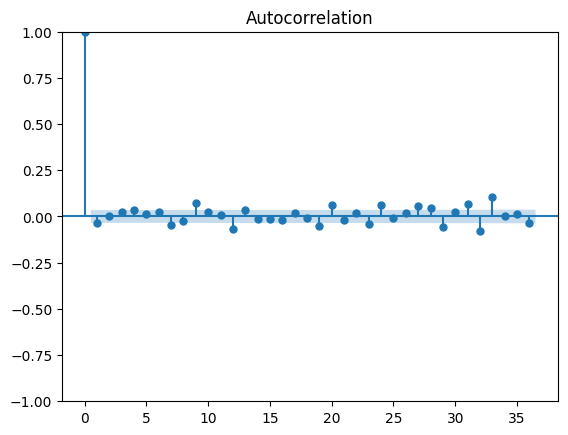

In [2667]:
# acf
acf_plot = plot_acf(df_first_diffs.FirstDifference)
acf_plot.savefig('btcusd_first_diff_acf.png')

### PACF Plot

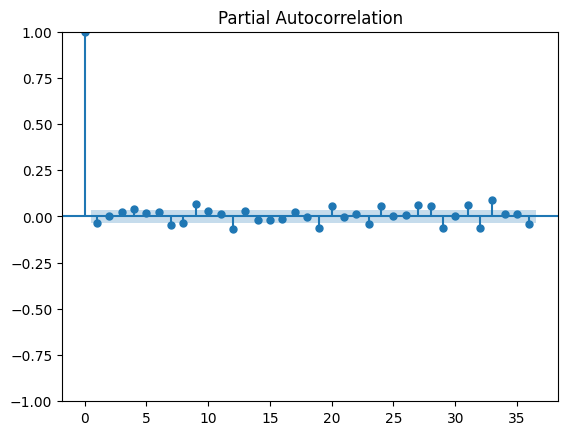

In [2668]:
# pacf
pacf_plot = plot_pacf(df_first_diffs.FirstDifference, method='ywm')

### ACF Plot Returns

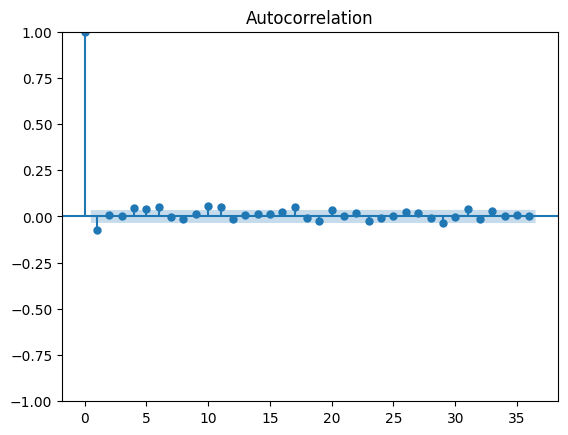

In [2669]:
# acf
acf_plot = plot_acf(df_returns.X_BTCUSD_Close)
acf_plot.savefig('btcusd_pct_change_acf.png')

### PACF Plot Returns

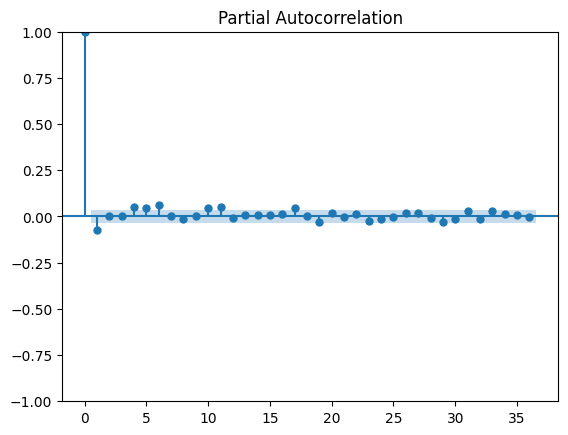

In [2670]:
# pacf
pacf_plot = plot_pacf(df_returns.X_BTCUSD_Close, method='ywm')

# Data Engineering

## Indicators Definitions

In [2671]:
# Moving Average
def MA(df, col_name, n):
    MA = pd.Series(df[col_name].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# Exponential Moving Average
def EMA(df, col_name, n):
    EMA = pd.Series(df[col_name].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# calculation of stochastic oscillator
def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

In [2672]:
# preprocess data into return pct
df_returns = data.copy()
if USE_CLOSE_PRICE:
    df_returns = df_returns.divide(df_returns["X_BTCUSD_Close"], axis="index")
    df_returns['y_Close_t+1'] = df_returns['X_BTCUSD_Close'].shift(-1) # add close t+1 price to row of time t
    df_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_returns.dropna(inplace=True)
else:
    df_returns = df_returns[["X_BTCUSD_Open", "X_BTCUSD_High", "X_BTCUSD_Low", "X_BTCUSD_Close", "X_BTCUSD_Volume"]].pct_change()
    df_returns['y_Close_t+1'] = df_returns['X_BTCUSD_Close'].shift(-1) # add close t+1 price to row of time t
    df_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_returns.dropna(inplace=True)

In [2673]:
df_returns

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1
2013-10-07,0.013197,0.013197,0.013197,0.013197,0.000000,0.004611
2013-10-08,0.002427,0.004692,0.002346,0.004611,38.916000,-0.002738
2013-10-09,0.000862,-0.001394,-0.000484,-0.002738,-0.292765,0.016311
2013-10-10,0.014781,0.014862,0.016231,0.016311,-0.291534,0.000000
2013-10-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.009058
...,...,...,...,...,...,...
2022-06-25,0.006202,0.002531,0.007607,0.012437,-0.627109,-0.021011
2022-06-26,0.012025,0.012877,0.003265,-0.021011,0.042287,-0.014603
2022-06-27,-0.021111,-0.015471,-0.021544,-0.014603,1.077073,-0.022432
2022-06-28,-0.014608,-0.015802,-0.016591,-0.022432,-0.182016,-0.008167


In [2674]:
df_returns.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000
mean,0.002515,0.002453,0.002781,0.002549,75.488647,0.002543
std,0.042619,0.041802,0.048073,0.043565,2820.516245,0.043565
min,-0.390803,-0.247047,-0.436818,-0.389423,-0.999995,-0.389423
25%,-0.014596,-0.013261,-0.013101,-0.014949,-0.340361,-0.014949
50%,0.001402,-0.000796,0.003613,0.001607,-0.011170,0.001578
75%,0.019221,0.014902,0.019676,0.019636,0.525530,0.019636
max,0.410253,0.424208,0.423763,0.424208,131077.200071,0.424208


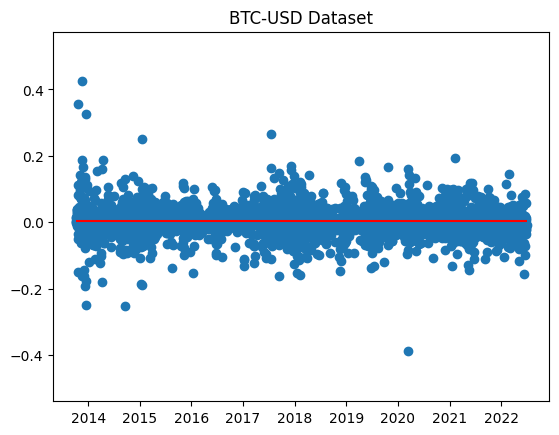

In [2675]:
dataset = df_returns['X_BTCUSD_Close']
mean = df_returns['X_BTCUSD_Close'].mean()
std = df_returns['X_BTCUSD_Close'].std()
min_value = min(dataset)
max_value = max(dataset)

plt.title("BTC-USD Dataset")
plt.ylim(min_value - 0.15, max_value + 0.15)
plt.scatter(x=df_returns.index, y=df_returns['X_BTCUSD_Close'])
plt.hlines(y=mean, xmin=start_date, xmax=end_date, colors="r")
plt.savefig('btcusd_pct_change.png')

## Bin Values for MultiClass Classification

In [2676]:
buy_bin = df_returns.X_BTCUSD_Close.mean() + df_returns.X_BTCUSD_Close.std() * 0.5
sell_bin = df_returns.X_BTCUSD_Close.mean() - df_returns.X_BTCUSD_Close.std() * 0.5
# buy_bin = df_returns.Close.std() * 0.5
# sell_bin = -df_returns.Close.std() * 0.5

In [2677]:
c = pd.cut(df_returns["y_Close_t+1"], bins=[-np.inf,sell_bin,buy_bin,np.inf],labels=["Sell","Hold","Buy"]).astype("category")
# c = pd.cut(df_returns["Close_t+1"], bins=[-np.inf,-0.01,0.01,np.inf],labels=["Sell","Hold","Buy"]).astype("category")
c

2013-10-07    Hold
2013-10-08    Hold
2013-10-09    Hold
2013-10-10    Hold
2013-10-11    Hold
              ... 
2022-06-25    Sell
2022-06-26    Hold
2022-06-27    Sell
2022-06-28    Hold
2022-06-29    Hold
Freq: D, Name: y_Close_t+1, Length: 3188, dtype: category
Categories (3, object): ['Sell' < 'Hold' < 'Buy']

In [2678]:
# convert to category code
df_returns['y_Close_t+1'] = c.cat.codes
d = dict(enumerate(c.cat.categories)) # mapping of code to label
d

{0: 'Sell', 1: 'Hold', 2: 'Buy'}

In [2679]:
df_returns.head()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1
2013-10-07,0.013197,0.013197,0.013197,0.013197,0.000000,1
2013-10-08,0.002427,0.004692,0.002346,0.004611,38.916000,1
2013-10-09,0.000862,-0.001394,-0.000484,-0.002738,-0.292765,1
2013-10-10,0.014781,0.014862,0.016231,0.016311,-0.291534,1
2013-10-11,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [2680]:
df_returns['y_Close_t+1'].value_counts()

1    1846
0     675
2     667
Name: y_Close_t+1, dtype: int64

In [2681]:
df_returns.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000
mean,0.002515,0.002453,0.002781,0.002549,75.488647,0.997491
std,0.042619,0.041802,0.048073,0.043565,2820.516245,0.648906
min,-0.390803,-0.247047,-0.436818,-0.389423,-0.999995,0.000000
25%,-0.014596,-0.013261,-0.013101,-0.014949,-0.340361,1.000000
50%,0.001402,-0.000796,0.003613,0.001607,-0.011170,1.000000
75%,0.019221,0.014902,0.019676,0.019636,0.525530,1.000000
max,0.410253,0.424208,0.423763,0.424208,131077.200071,2.000000


## Include Feature Engineering

### Check for no missing dates

In [2682]:
feature_engineering_data = df_returns.copy()
fx_lst = [df_spx, df_dji, df_ndq, df_shc, df_ukx, df_usdgbp, df_usdcny, df_usdjpy, df_usdeur, df_usdchf]
for df in fx_lst:
    s = df.head(1).index.item()
    e = df.tail(1).index.item()
    print("Start date: ", s)
    print("End date: ", e)
    print("Dates Missing")
    print(pd.date_range(start = s, end = e ).difference(df.index))

Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-08 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2014-11-24 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-08 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Start date:  2013-10-07 00:00:00
End date:  2022-06-30 00:00:00
Dates Missing
DatetimeInde

### Add price derived features

In [2683]:
fx_lst = [df_spx, df_dji, df_ndq, df_shc, df_ukx, df_usdgbp, df_usdcny, df_usdjpy, df_usdeur, df_usdchf]
col = ["Close", "Close", "Close", "Close", "Close", "close", "close", "close", "close"]
# feature_engineering_data['X_BTCUSD_MA10'] = MA(feature_engineering_data, 'X_BTCUSD_Close', 10)
# feature_engineering_data['X_BTCUSD_MA30'] = MA(feature_engineering_data, 'X_BTCUSD_Close', 30)
# feature_engineering_data['X_BTCUSD_MA200'] = MA(feature_engineering_data, 'X_BTCUSD_Close', 200)
# feature_engineering_data['X_BTCUSD_EMA10'] = EMA(feature_engineering_data, 'X_BTCUSD_Close', 10)
# feature_engineering_data['X_BTCUSD_EMA30'] = EMA(feature_engineering_data, 'X_BTCUSD_Close', 30)
# feature_engineering_data['X_BTCUSD_EMA200'] = EMA(feature_engineering_data, 'X_BTCUSD_Close', 200)
# feature_engineering_data['X_BTCUSD_RSI10'] = RSI(feature_engineering_data['X_BTCUSD_Close'], 10)
# feature_engineering_data['X_BTCUSD_RSI30'] = RSI(feature_engineering_data['X_BTCUSD_Close'], 30)
# feature_engineering_data['X_BTCUSD_RSI200'] = RSI(feature_engineering_data['X_BTCUSD_Close'], 200)
# feature_engineering_data['X_BTCUSD_MOM10'] = MOM(feature_engineering_data['X_BTCUSD_Close'], 10)
# feature_engineering_data['X_BTCUSD_MOM30'] = MOM(feature_engineering_data['X_BTCUSD_Close'], 30)
# feature_engineering_data['X_BTCUSD_MOM200'] = MOM(feature_engineering_data['X_BTCUSD_Close'], 200)
feature_engineering_data['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10)
feature_engineering_data['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30)
feature_engineering_data['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200)
feature_engineering_data['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10)
feature_engineering_data['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30)
feature_engineering_data['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200)
feature_engineering_data['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
feature_engineering_data['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
feature_engineering_data['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
feature_engineering_data['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10)
feature_engineering_data['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30)
feature_engineering_data['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200)
# feature_engineering_data['X_BTCUSD_STOK10'] = STOK(data['X_BTCUSD_Close'], data['X_BTCUSD_Low'], data['X_BTCUSD_High'], 10)
# feature_engineering_data['X_BTCUSD_STOK30'] = STOK(data['X_BTCUSD_Close'], data['X_BTCUSD_Low'], data['X_BTCUSD_High'], 30)
# feature_engineering_data['X_BTCUSD_STOK200'] = STOK(data['X_BTCUSD_Close'], data['X_BTCUSD_Low'], data['X_BTCUSD_High'], 200)

feature_engineering_data

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1,X_BTCUSD_MA10,X_BTCUSD_MA30,X_BTCUSD_MA200,X_BTCUSD_EMA10,X_BTCUSD_EMA30,X_BTCUSD_EMA200,X_BTCUSD_RSI10,X_BTCUSD_RSI30,X_BTCUSD_RSI200,X_BTCUSD_MOM10,X_BTCUSD_MOM30,X_BTCUSD_MOM200
2013-10-07,0.013197,0.013197,0.013197,0.013197,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,0.002427,0.004692,0.002346,0.004611,38.916000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-09,0.000862,-0.001394,-0.000484,-0.002738,-0.292765,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-10,0.014781,0.014862,0.016231,0.016311,-0.291534,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-11,0.000000,0.000000,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-25,0.006202,0.002531,0.007607,0.012437,-0.627109,0,20527.98,25977.673333,38654.5470,21501.764253,24960.775384,37084.833786,38.400646,36.347081,45.894060,-1085.1,-7712.4,-29175.6
2022-06-26,0.012025,0.012877,0.003265,-0.021011,0.042287,1,20593.68,25725.783333,38507.0880,21414.770753,24706.744714,36925.017529,36.126314,35.735172,45.796895,657.0,-7556.7,-29491.8
2022-06-27,-0.021111,-0.015471,-0.021544,-0.014603,1.077073,0,20622.02,25448.993333,38372.7615,21287.776070,24449.296668,36763.736758,34.578058,35.316679,45.730687,283.4,-8303.7,-26865.3
2022-06-28,-0.014608,-0.015802,-0.016591,-0.022432,-0.182016,1,20752.18,25142.366667,38237.9280,21099.380421,24178.477528,36599.436890,32.253264,34.680705,45.630332,1301.6,-9198.8,-26966.7


### Add supplementary data sources

In [2684]:
feature_engineering_data['X_SPX_Close'] = df_spx['Close']
feature_engineering_data['X_DJI_Close'] = df_dji['Close']
feature_engineering_data['X_NDQ_Close'] = df_ndq['Close']
feature_engineering_data['X_SHC_Close'] = df_shc['Close']
feature_engineering_data['X_UKX_Close'] = df_ukx['Close']
feature_engineering_data['X_USDGBP_Close'] = df_usdgbp['close']
feature_engineering_data['X_USDCNY_Close'] = df_usdcny['close']
feature_engineering_data['X_USDJPY_Close'] = df_usdjpy['close']
feature_engineering_data['X_USDEUR_Close'] = df_usdeur['close']
feature_engineering_data['X_USDCHF_Close'] = df_usdchf['close']

# feature_engineering_data

In [2685]:
feature_engineering_data.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_engineering_data.dropna(inplace=True)

In [2686]:
feature_engineering_data.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1,X_BTCUSD_MA10,X_BTCUSD_MA30,X_BTCUSD_MA200,X_BTCUSD_EMA10,...,X_SPX_Close,X_DJI_Close,X_NDQ_Close,X_SHC_Close,X_UKX_Close,X_USDGBP_Close,X_USDCNY_Close,X_USDJPY_Close,X_USDEUR_Close,X_USDCHF_Close
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,...,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,0.002236,0.002115,0.002386,0.002245,49.120447,0.999279,12668.962096,12587.211635,11482.622347,12668.562486,...,0.000268,0.000248,0.000372,0.000169,0.000070,0.000106,0.000033,0.000062,0.000072,0.000008
std,0.039580,0.037342,0.043008,0.039974,2489.210244,0.641738,16661.139456,16593.060215,15427.560773,16642.877655,...,0.009666,0.009755,0.011244,0.011501,0.008890,0.005079,0.002016,0.004447,0.004152,0.005013
min,-0.390803,-0.247047,-0.384333,-0.389423,-0.999995,0.000000,212.667667,225.700348,246.193490,221.982889,...,-0.119841,-0.129265,-0.123212,-0.084907,-0.108745,-0.031045,-0.014181,-0.036507,-0.029181,-0.155974
25%,-0.014406,-0.012589,-0.012332,-0.014585,-0.320117,1.000000,668.733000,663.211058,571.255070,670.582905,...,-0.001341,-0.001474,-0.001547,-0.001835,-0.002189,-0.001724,-0.000442,-0.001344,-0.001552,-0.001286
50%,0.001662,-0.000841,0.003987,0.001726,-0.013547,1.000000,6614.320000,6656.066667,6591.831000,6636.788718,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.018830,0.014838,0.019143,0.019145,0.469969,1.000000,11544.230000,11203.824167,9728.287250,11566.497922,...,0.002828,0.002780,0.004037,0.003322,0.003035,0.001964,0.000515,0.001593,0.001741,0.001730
max,0.266024,0.377128,0.292326,0.266024,131077.200071,2.000000,64681.520000,62779.860000,49448.209000,64384.598499,...,0.093828,0.113650,0.093459,0.057636,0.090535,0.088797,0.018552,0.029816,0.025038,0.024310


## Chart Indicators over Time

Text(0, 0.5, 'Price (USD)')

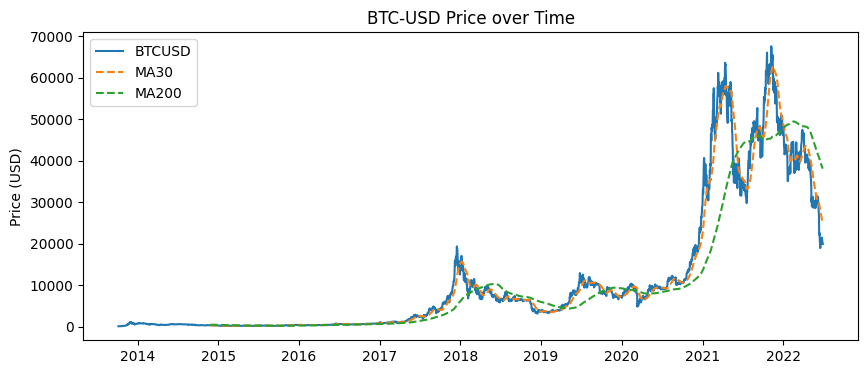

In [2687]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close, label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_MA10, label="MA10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MA30, label="MA30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MA200, label="MA200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

### Moving Average

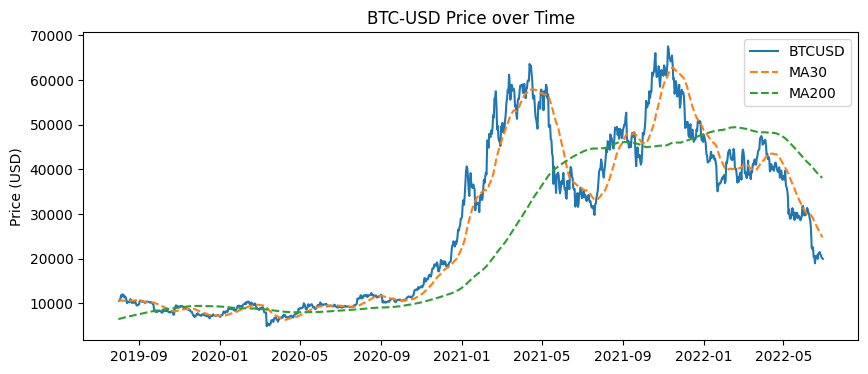

In [2688]:
# plot the price of Bitcoin over time
total_rows = len(data.X_BTCUSD_Close)
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close[-total_rows//3:], label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_MA10[-total_rows//3:], label="MA10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MA30[-total_rows//3:], label="MA30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MA200[-total_rows//3:], label="MA200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.savefig('btcusd_ma.png')

### EMA

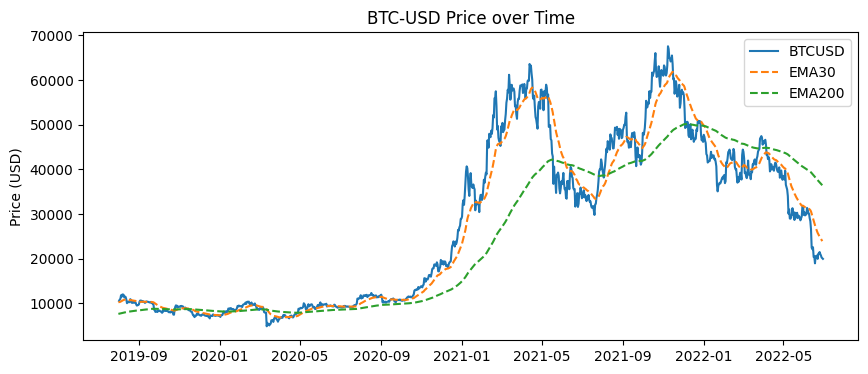

In [2689]:
# plot the price of Bitcoin over time
total_rows = len(data.X_BTCUSD_Close)
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close[-total_rows//3:], label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_EMA10[-total_rows//3:], label="EMA10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_EMA30[-total_rows//3:], label="EMA30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_EMA200[-total_rows//3:], label="EMA200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.savefig('btcusd_ema.png')

### Momentum

Text(0, 0.5, 'Price (USD)')

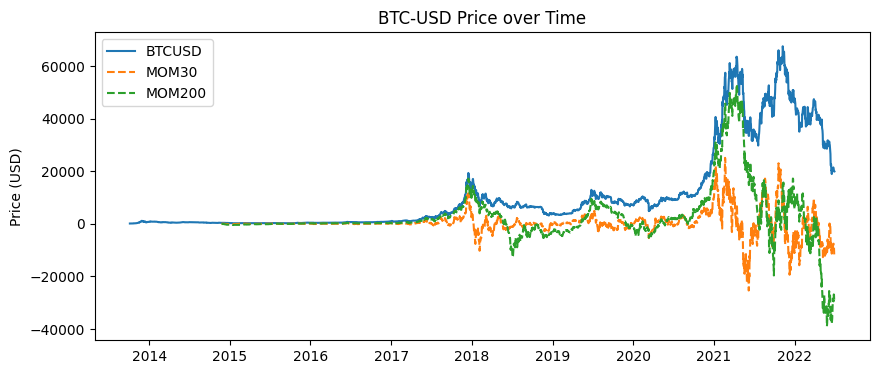

In [2690]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close, label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_MOM10, label="MOM10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM30, label="MOM30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM200, label="MOM200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

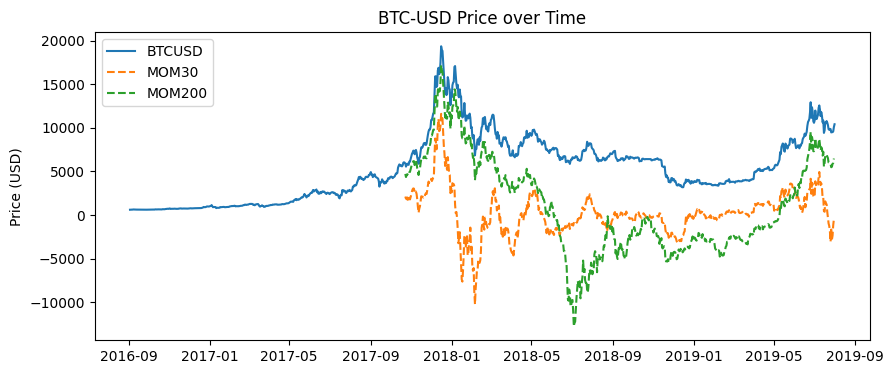

In [2691]:
# plot the price of Bitcoin over time
total_rows = len(data.X_BTCUSD_Close)
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close[total_rows//3:-total_rows//3], label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_MOM10[total_rows//3:-total_rows//3], label="MOM10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM30[total_rows//3:-total_rows//3], label="MOM30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM200[total_rows//3:-total_rows//3], label="MOM200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

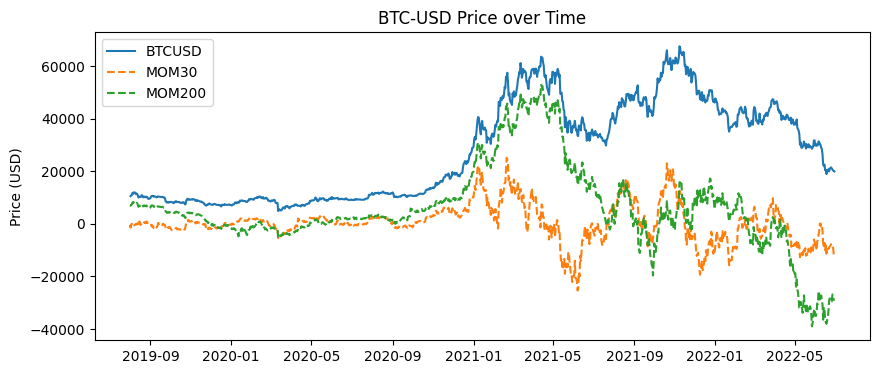

In [2692]:
# plot the price of Bitcoin over time
total_rows = len(data.X_BTCUSD_Close)
plt.figure(figsize=(10,4))
plt.plot(data.X_BTCUSD_Close[-total_rows//3:], label="BTCUSD")
# plt.plot(feature_engineering_data.X_BTCUSD_MOM10[-total_rows//3:], label="MOM10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM30[-total_rows//3:], label="MOM30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_MOM200[-total_rows//3:], label="MOM200", linestyle="--")
plt.legend()
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

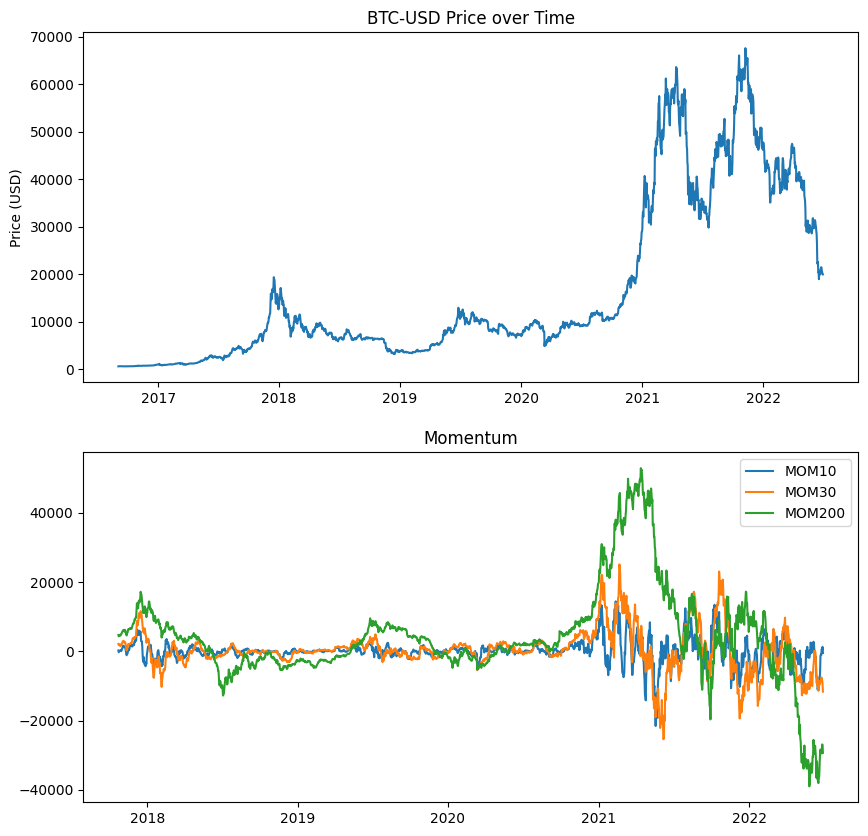

In [2693]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(data.X_BTCUSD_Close[total_rows//3:], label="BTCUSD")
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.subplot(212)
plt.title('Momentum')
plt.plot(feature_engineering_data.X_BTCUSD_MOM10[total_rows//3:], label="MOM10")
plt.plot(feature_engineering_data.X_BTCUSD_MOM30[total_rows//3:], label="MOM30")
plt.plot(feature_engineering_data.X_BTCUSD_MOM200[total_rows//3:], label="MOM200")
plt.legend()

### RSI

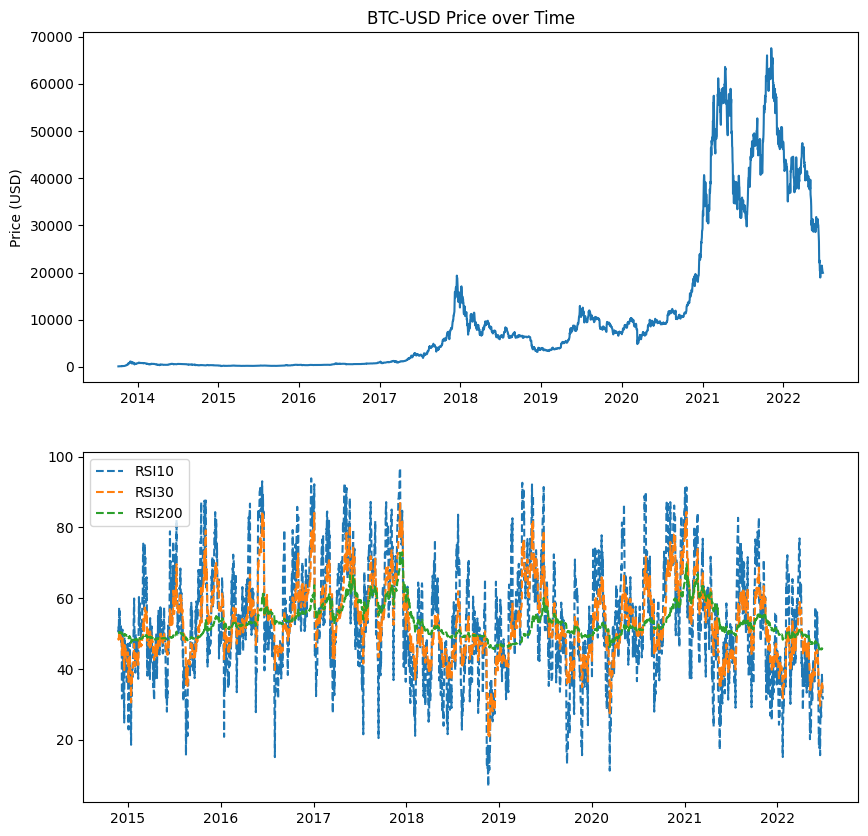

In [2694]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(data.X_BTCUSD_Close, label="BTCUSD")
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.subplot(212)
plt.plot(feature_engineering_data.X_BTCUSD_RSI10, label="RSI10", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_RSI30, label="RSI30", linestyle="--")
plt.plot(feature_engineering_data.X_BTCUSD_RSI200, label="RSI200", linestyle="--")
plt.legend()

2127 2774


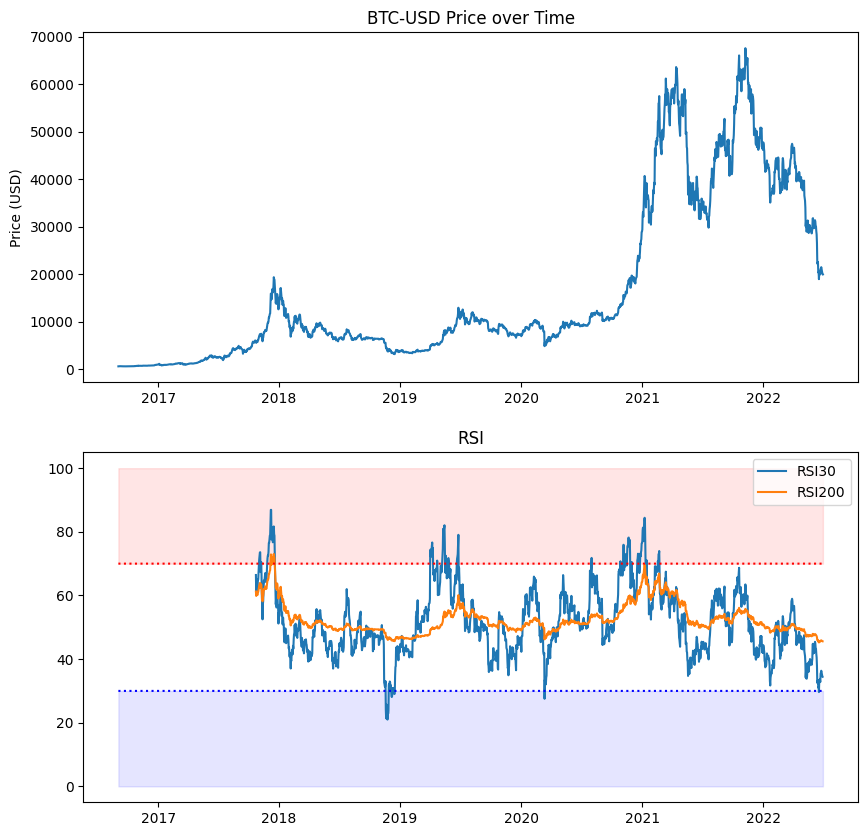

In [2695]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(data.X_BTCUSD_Close[total_rows//3:], label="BTCUSD")
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.subplot(212)
plt.title('RSI')
# plt.plot(feature_engineering_data.X_BTCUSD_RSI10[-total_rows//3:], label="RSI10")
plt.plot(feature_engineering_data.X_BTCUSD_RSI30[total_rows//3:], label="RSI30")
plt.plot(feature_engineering_data.X_BTCUSD_RSI200[total_rows//3:], label="RSI200")
# fill area above 70 and below 30
print(len(data.X_BTCUSD_Close) - total_rows//3, len(feature_engineering_data.X_BTCUSD_RSI30))
xdate = [x.date() for x in data.X_BTCUSD_Close[total_rows//3:].index]
plt.fill_between(xdate, np.ones(len(xdate))*30, color="blue", alpha=0.1)
plt.fill_between(xdate, np.ones(len(xdate))*70, np.ones(len(xdate))*100, color="red", alpha=0.1)

# draw dotted lines at 70 and 30
plt.plot(xdate, np.ones(len(xdate))*30, color="blue", linestyle="dotted")
plt.plot(xdate, np.ones(len(xdate))*70, color="red", linestyle="dotted")
# plt.ylabel('RSI')
plt.legend()

plt.savefig('btcusd_rsi.png')

2127 2774


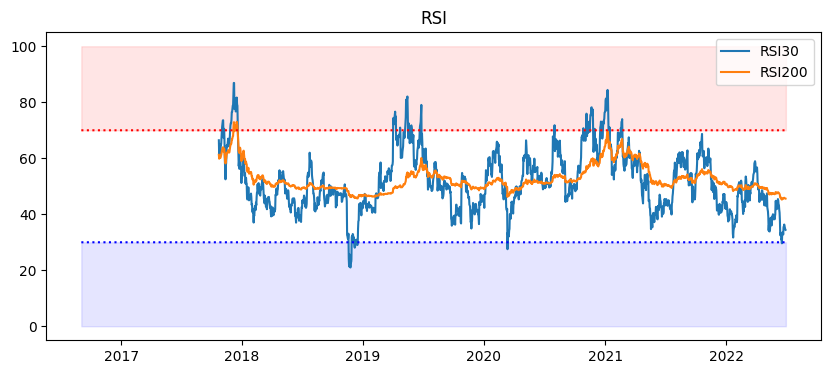

In [2696]:
# plot the price of Bitcoin over time
plt.figure(figsize=(10,4))
# plt.subplot(211)
# plt.plot(data.X_BTCUSD_Close[total_rows//3:], label="BTCUSD")
# plt.title('%s Price over Time'%ticker)
# plt.ylabel('Price (USD)')
# plt.subplot(212)
plt.title('RSI')
# plt.plot(feature_engineering_data.X_BTCUSD_RSI10[-total_rows//3:], label="RSI10")
plt.plot(feature_engineering_data.X_BTCUSD_RSI30[total_rows//3:], label="RSI30")
plt.plot(feature_engineering_data.X_BTCUSD_RSI200[total_rows//3:], label="RSI200")
# fill area above 70 and below 30
print(len(data.X_BTCUSD_Close) - total_rows//3, len(feature_engineering_data.X_BTCUSD_RSI30))
xdate = [x.date() for x in data.X_BTCUSD_Close[total_rows//3:].index]
plt.fill_between(xdate, np.ones(len(xdate))*30, color="blue", alpha=0.1)
plt.fill_between(xdate, np.ones(len(xdate))*70, np.ones(len(xdate))*100, color="red", alpha=0.1)

# draw dotted lines at 70 and 30
plt.plot(xdate, np.ones(len(xdate))*30, color="blue", linestyle="dotted")
plt.plot(xdate, np.ones(len(xdate))*70, color="red", linestyle="dotted")
plt.legend()

## PCA

In [2742]:
pca_scaler = MinMaxScaler()

standard_data_scaled = feature_engineering_data.iloc[:split_idx,:].copy()
standard_data_scaled['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10).pct_change()
standard_data_scaled['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30).pct_change()
standard_data_scaled['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200).pct_change()
standard_data_scaled['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10).pct_change()
standard_data_scaled['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30).pct_change()
standard_data_scaled['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200).pct_change()
standard_data_scaled['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
standard_data_scaled['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
standard_data_scaled['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
standard_data_scaled['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10).pct_change()
standard_data_scaled['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30).pct_change()
standard_data_scaled['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200).pct_change()
standard_data_scaled = standard_data_scaled.filter(like="X_")

standard_data_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
standard_data_scaled.dropna(inplace=True)

standard_data_scaled = pd.DataFrame(pca_scaler.fit_transform(standard_data_scaled), columns = standard_data_scaled.columns)
# standard_data_scaled = pd.DataFrame(standard_data_scaled, columns = feature_engineering_data.columns)
pca = PCA()
pca.fit(standard_data_scaled)

PCA()

In [2743]:
standard_data_scaled.describe()

,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,X_BTCUSD_MA10,X_BTCUSD_MA30,X_BTCUSD_MA200,X_BTCUSD_EMA10,X_BTCUSD_EMA30,...,X_SPX_Close,X_DJI_Close,X_NDQ_Close,X_SHC_Close,X_UKX_Close,X_USDGBP_Close,X_USDCNY_Close,X_USDJPY_Close,X_USDEUR_Close,X_USDCHF_Close
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,0.598325,0.399164,0.571393,0.597517,0.000543,0.514397,0.464090,0.345251,0.506520,0.404677,...,0.563939,0.580383,0.569811,0.596480,0.751689,0.260455,0.388604,0.549903,0.553558,0.865245
std,0.061030,0.062155,0.063955,0.062018,0.022702,0.109556,0.120057,0.157993,0.082512,0.101955,...,0.041768,0.040846,0.046275,0.087574,0.056507,0.043968,0.065466,0.071320,0.081496,0.030237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.575644,0.376343,0.550877,0.574659,0.000005,0.460492,0.389437,0.218092,0.468513,0.347936,...,0.557669,0.574270,0.562006,0.582191,0.737215,0.244813,0.374566,0.526739,0.522295,0.858011
50%,0.597179,0.394558,0.573453,0.596397,0.000007,0.512806,0.459706,0.360470,0.503234,0.396402,...,0.563394,0.579939,0.568660,0.595658,0.752458,0.259052,0.386194,0.550442,0.552122,0.865158
75%,0.622310,0.418087,0.594634,0.622144,0.000011,0.571600,0.524913,0.427439,0.546069,0.451862,...,0.573758,0.591246,0.584195,0.618600,0.771685,0.276579,0.403801,0.575006,0.586275,0.875018
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2699]:
pca.explained_variance_ratio_

array([5.60234081e-01, 1.47299238e-01, 4.74529618e-02, 4.01549399e-02,
       3.60336305e-02, 2.75495906e-02, 2.06564898e-02, 1.84435789e-02,
       1.74704010e-02, 1.46043005e-02, 1.21592779e-02, 1.12030593e-02,
       1.00689673e-02, 6.00613896e-03, 5.82575850e-03, 4.95289425e-03,
       3.50778178e-03, 2.90538006e-03, 2.41247218e-03, 2.26192494e-03,
       1.96156575e-03, 1.94283132e-03, 1.93853807e-03, 1.42413676e-03,
       1.00197766e-03, 4.43323291e-04, 8.47602471e-05])

### PCA Plot

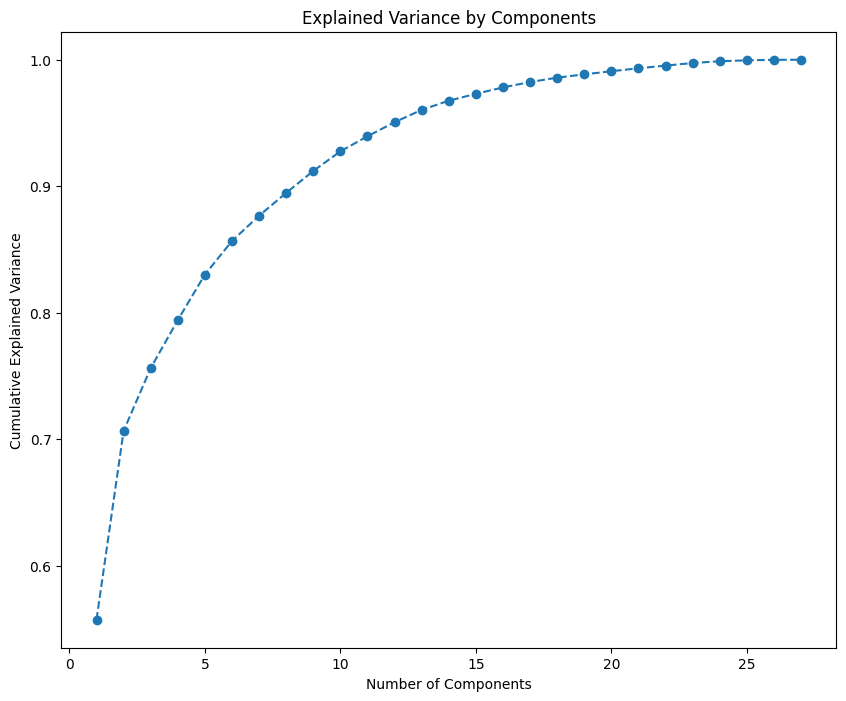

In [2781]:
plt.figure(figsize = (10,8))
plt.plot(range(1,28), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.savefig('pca_plot.png')

What is the general rule of thumb?
Most recommend keeping at least 80% of the variance.

From our plot here, we see that with about 4 components, we roughly explain about 92% of the variance. However, since we want to keep as much data as possible but try to reduce the number of insignificant features for the model, we choose our components to be 10 and 15.

## KMeans

In [2701]:
kmeans_scaler = MinMaxScaler()

minmax_data_scaled = feature_engineering_data.iloc[:split_idx,:].copy()
minmax_data_scaled['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10).pct_change()
minmax_data_scaled['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30).pct_change()
minmax_data_scaled['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200).pct_change()
minmax_data_scaled['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10).pct_change()
minmax_data_scaled['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30).pct_change()
minmax_data_scaled['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200).pct_change()
minmax_data_scaled['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
minmax_data_scaled['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
minmax_data_scaled['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
minmax_data_scaled['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10).pct_change()
minmax_data_scaled['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30).pct_change()
minmax_data_scaled['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200).pct_change()


minmax_data_scaled = kmeans_scaler.fit_transform(minmax_data_scaled)
minmax_data_scaled = pd.DataFrame(minmax_data_scaled, columns = feature_engineering_data.columns)

### Inertia Plot

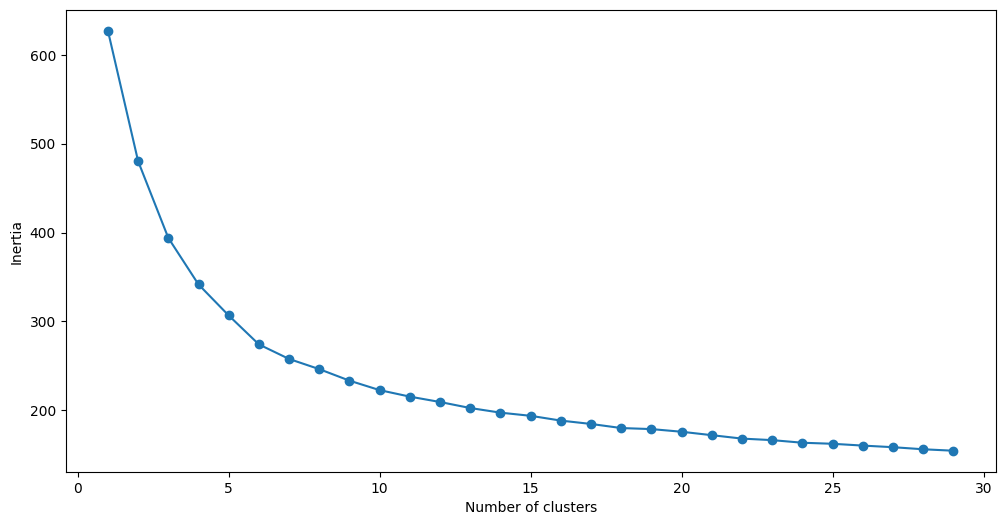

In [2618]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,30):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(minmax_data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('inertia_plot.png')

Using the Elbow method (explain what the Elbow method is showing), we use 2 as the number of clusters.

### Silhouette Method Evaluation

For n_clusters = 2 The average silhouette_score is : 0.23361090201803433


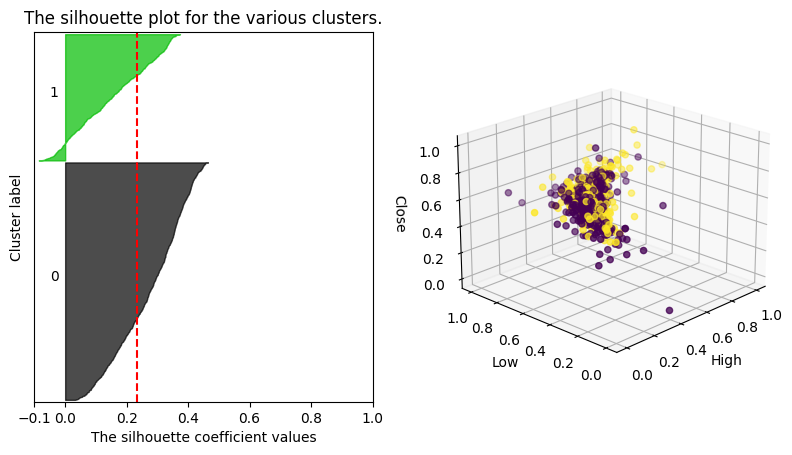

For n_clusters = 3 The average silhouette_score is : 0.25568693214517757


<Figure size 640x480 with 0 Axes>

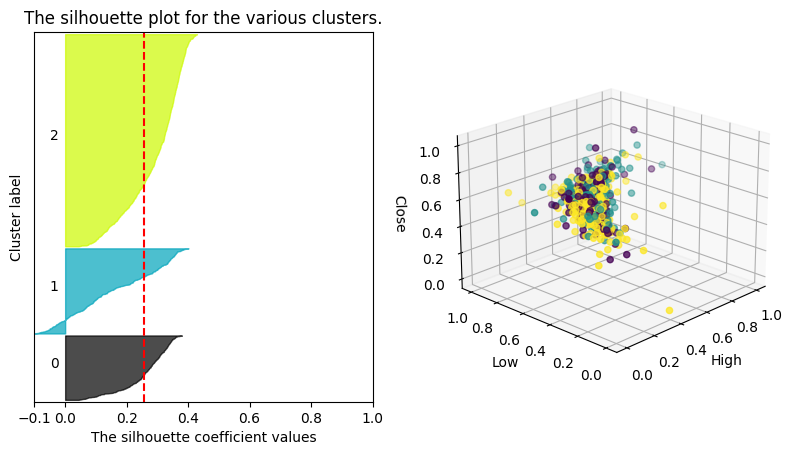

For n_clusters = 4 The average silhouette_score is : 0.2717179605907287


<Figure size 640x480 with 0 Axes>

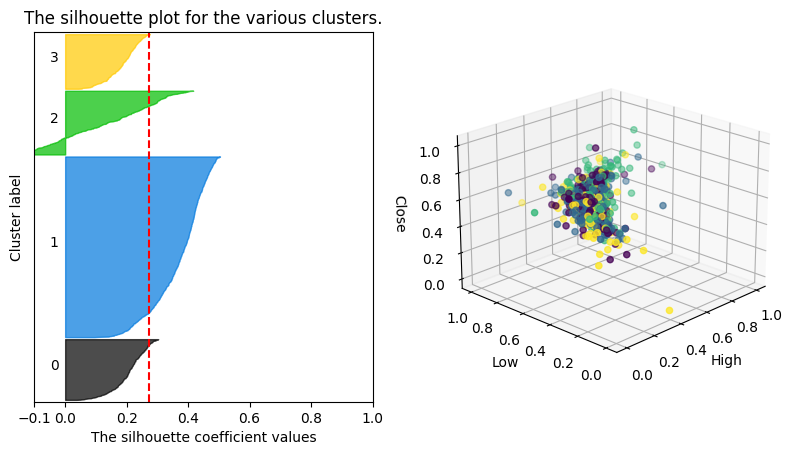

For n_clusters = 5 The average silhouette_score is : 0.20881620610082924


<Figure size 640x480 with 0 Axes>

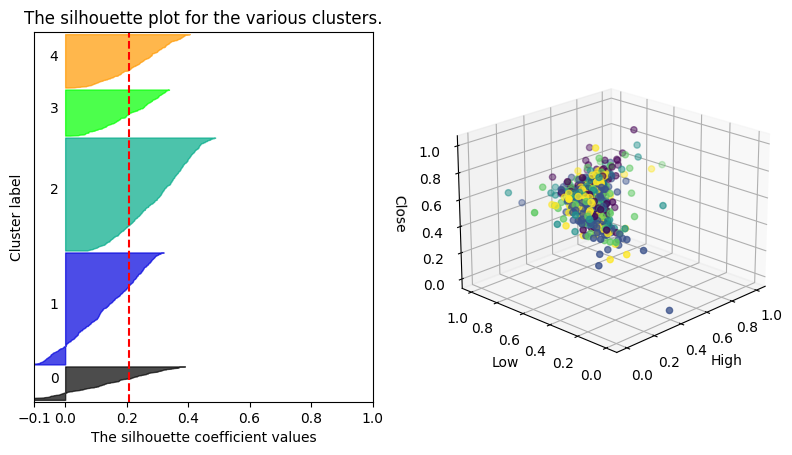

For n_clusters = 6 The average silhouette_score is : 0.21590446119246026


<Figure size 640x480 with 0 Axes>

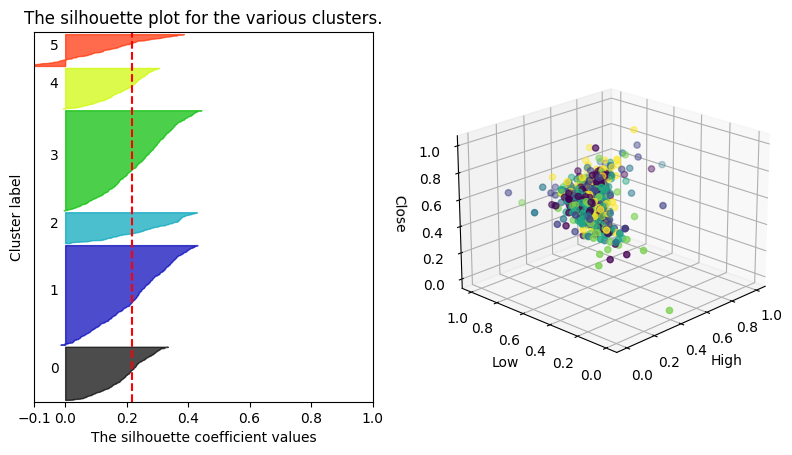

<Figure size 640x480 with 0 Axes>

In [2626]:
range_n_clusters = [x for x in range(2,7)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=plt.figaspect(0.5))
    # fig = plt.figure(figsize=(15, 9))
    
    # fig.set_size_inches(18, 7)
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(minmax_data_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(minmax_data_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(minmax_data_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(minmax_data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2 = fig.add_subplot(122, projection="3d", elev=21, azim=-136)
    ax2.scatter(
        minmax_data_scaled["X_BTCUSD_High"], minmax_data_scaled["X_BTCUSD_Low"], minmax_data_scaled["X_BTCUSD_Close"], 
        c=cluster_labels.astype(float)
    )
    ax2.set_xlabel('High')
    ax2.set_ylabel('Low')
    ax2.set_zlabel('Close')
    plt.show()

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    fig.savefig(f'silhouette_plot_{n_clusters}.png')


Text(0, 0.5, 'Price (USD)')

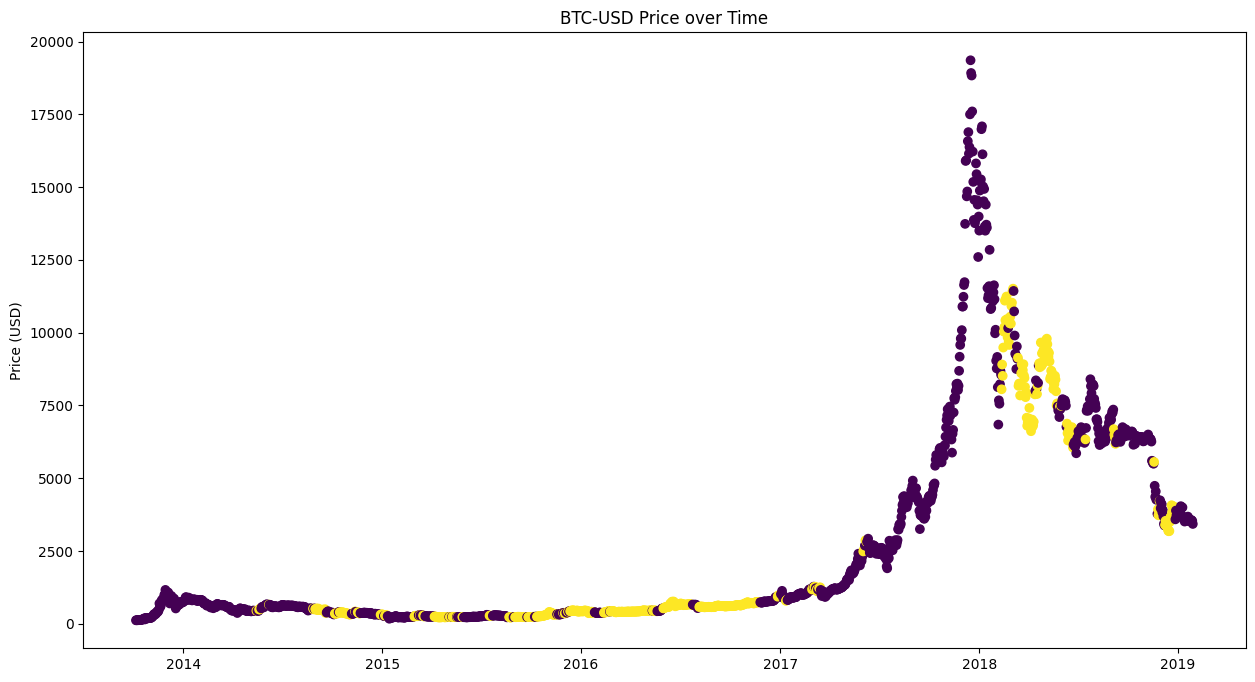

In [2324]:
kmeans = KMeans(n_clusters = 2, init='k-means++')
kmeans.fit(minmax_data_scaled)

# plot the price of Bitcoin over time
plt.figure(figsize=(15,8))
colors = ['red','green','cyan','darkorange','gold']
plt.scatter(data.iloc[:split_idx,:].copy().index, data.iloc[:split_idx,:].copy().X_BTCUSD_Close, c=kmeans.labels_, edgecolors=None)
# plt.plot(data.X_BTCUSD_Close, c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

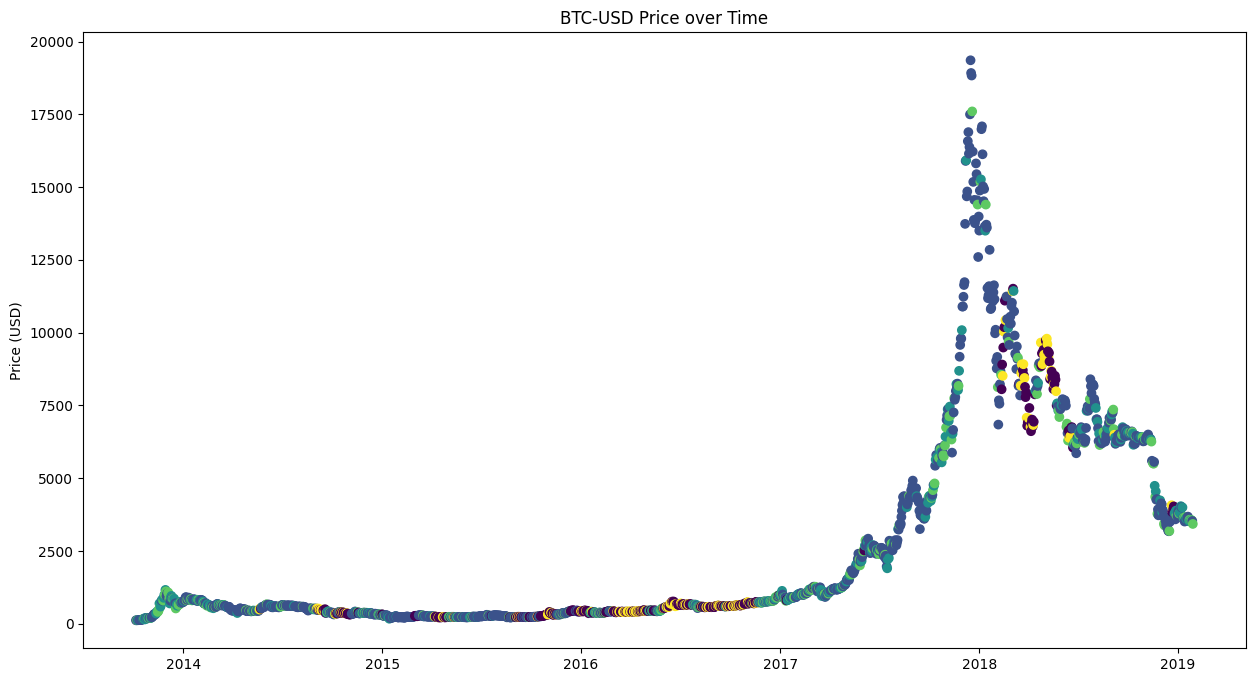

In [2632]:
kmeans = KMeans(n_clusters = 5, init='k-means++')
kmeans.fit(minmax_data_scaled)

# plot the price of Bitcoin over time
plt.figure(figsize=(15,8))
colors = ['red','green','cyan','darkorange','gold']
plt.scatter(data.iloc[:split_idx,:].copy().index, data.iloc[:split_idx,:].copy().X_BTCUSD_Close, c=kmeans.labels_, edgecolors=None)
# plt.plot(data.X_BTCUSD_Close, c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')
plt.savefig('btcusd_clusters_5.png')

## DBSCAN

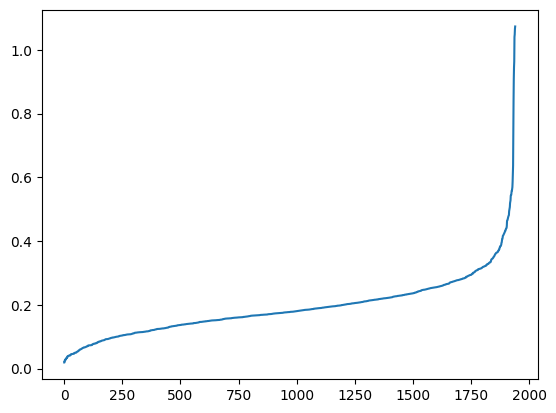

In [2326]:
neigh = NearestNeighbors(n_neighbors=56)
nbrs = neigh.fit(minmax_data_scaled)
distances, indices = nbrs.kneighbors(minmax_data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Text(0, 0.5, 'Price (USD)')

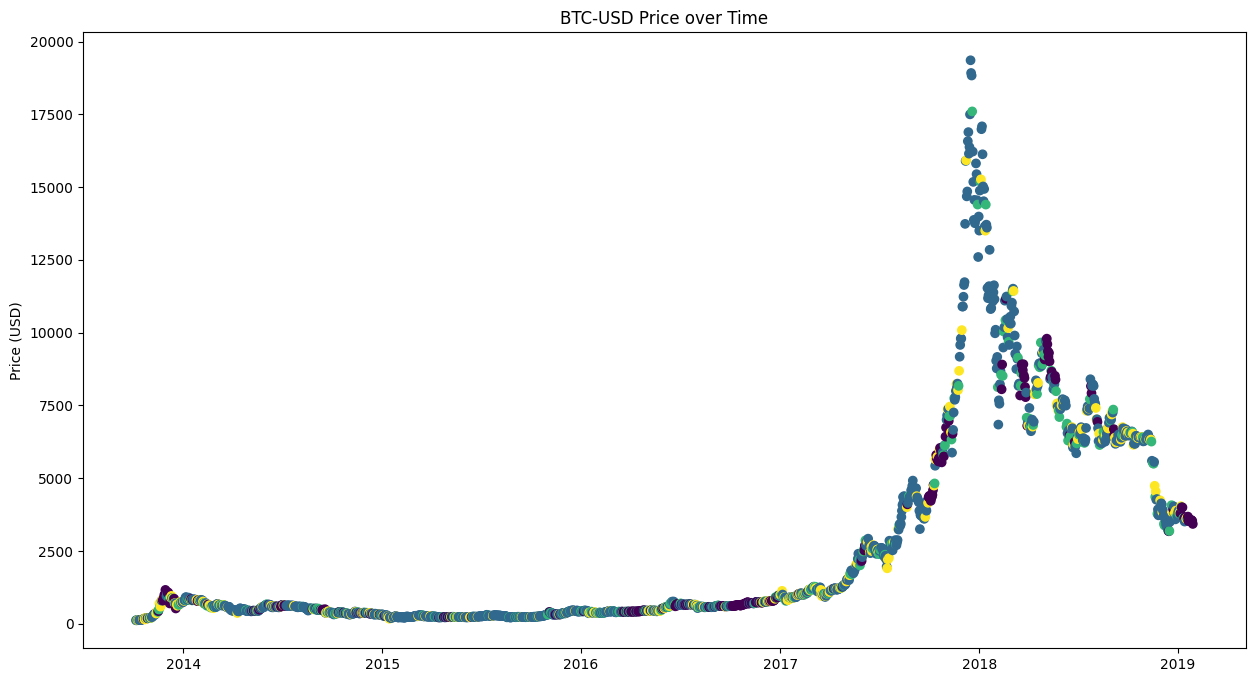

In [2327]:
epsilon = 0.35
min_samples = 56
dbsc = DBSCAN(eps=epsilon, min_samples=min_samples).fit(minmax_data_scaled)

# plot the price of Bitcoin over time
plt.figure(figsize=(15,8))
colors = ['red','green','cyan','darkorange','gold']
plt.scatter(data.iloc[:split_idx,:].copy().index, data.iloc[:split_idx,:].copy().X_BTCUSD_Close, c=dbsc.labels_, edgecolors=None)
# plt.plot(data.X_BTCUSD_Close, c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

## OPTICS

[0 0 0 ... 0 0 0]


Text(0, 0.5, 'Price (USD)')

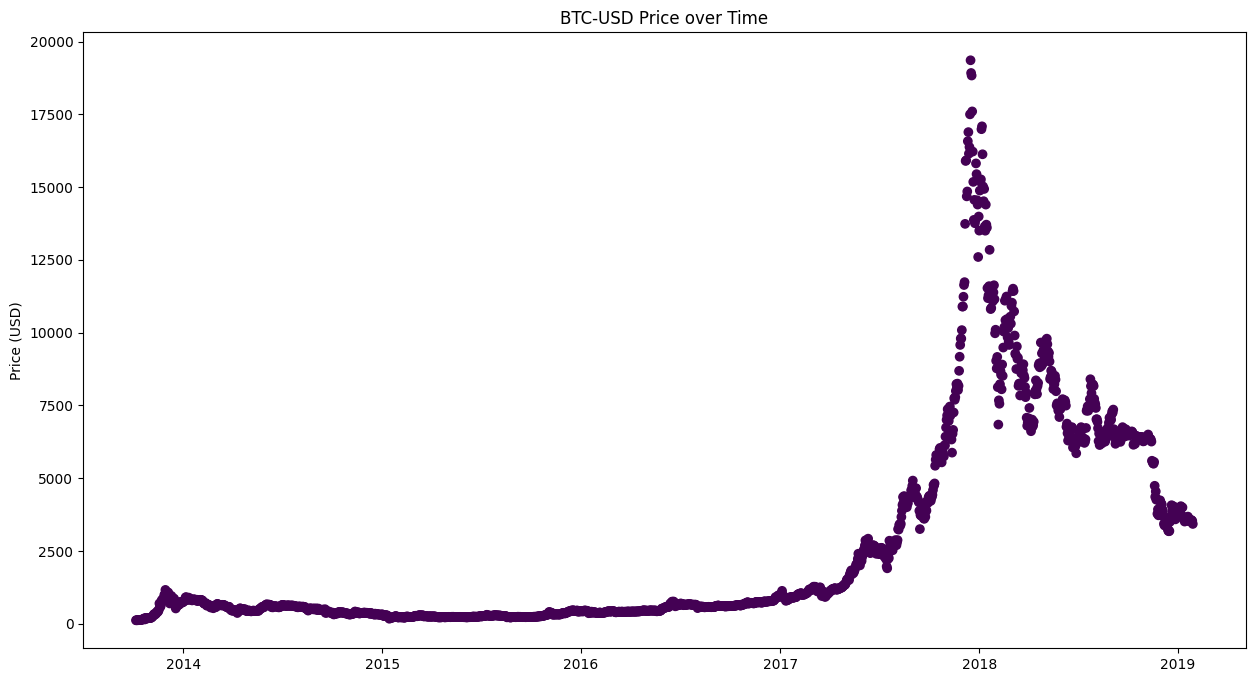

In [2328]:
optics = OPTICS(min_samples=56).fit(minmax_data_scaled)
print(optics.labels_)
# plot the price of Bitcoin over time
plt.figure(figsize=(15,8))
colors = ['red','green','cyan','darkorange','gold']
plt.scatter(data.iloc[:split_idx,:].copy().index, data.iloc[:split_idx,:].copy().X_BTCUSD_Close, c=optics.labels_, edgecolors=None)
# plt.plot(data.X_BTCUSD_Close, c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('%s Price over Time'%ticker)
plt.ylabel('Price (USD)')

# Backtesting

## Manual Calculation of Returns

In [2329]:
# return_data = data.iloc[:split_idx, :].drop(columns=['Transactions'])
# return_data["Close_t+1"] = data.pct_change()['Close'].shift(-1)
# return_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# return_data.dropna(inplace=True)

# return_pct = 1
# for idx, row in return_data.iterrows():

#     X = row[:-1]
#     y = row[-1:]
    
#     d = pd.DataFrame({
#         'Open': [X.Open],
#         'High': [X.High],
#         'Low': [X.Low],
#         'Close': [X.Close],
#         'Volume': [X.Volume],
#     })
    
#     if lgb_model.predict(d)[0] == 0:
#         return_pct *= (1 - y.values[0])
#     elif lgb_model.predict(d)[0] == 2:
#         return_pct *= (1 + y.values[0])
# print(return_pct * 100)
# return_data

## Exclude Feature Engineering

In [2782]:
non_feature_engineering_data = df_returns.copy()

X = non_feature_engineering_data.filter(like="X_") # all features are labelled with a prefix X_
y = non_feature_engineering_data.filter(like="y_") # dependent variable has a prefix y_
# Get index to split into Training and Test proportion set
split_idx = int(len(X) * TRAIN_PROPORTION)

# Partition dataset into Training and Test Data partitions
X_train = X.iloc[:split_idx, :]
y_train = y.iloc[:split_idx, :]

X_test = X.iloc[split_idx:, :]
y_test = y.iloc[split_idx:, :]

In [2783]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [2784]:
tscv = TimeSeriesSplit()
lgb_model = lgb.LGBMClassifier(objective='multiclass')

### Cross Validate LGB Model

In [2333]:
scores = cross_val_score(lgb_model, X_train, y_train.values.ravel(), cv=tscv, scoring='f1_micro')
print(scores)
print("F1 Score: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

[0.51752022 0.67385445 0.51212938 0.52021563 0.54447439]
F1 Score: 0.554 (+/- 0.061)


In [2334]:
scores = cross_val_score(lgb_model, X_train, y_train.values.ravel(), cv=tscv, scoring='accuracy')
print("Accuracy: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Accuracy: 0.554 (+/- 0.061)


In [2785]:
# tscv = TimeSeriesSplit()
# X_train, X_test, y_train, y_test = TimeSeriesSplit(X, y, test_size=0.3)
# model = lgb.LGBMClassifier(objective='multiclass')
start = time.time()
print("Starting model.fit \n")
lgb_model.fit(X_train, y_train.values.ravel())
print(f'Time to fit: {time.time() - start}')
start = time.time()

print("Starting model.predict \n")
predicted_y = lgb_model.predict(X_test)
print(f'Time to predict: {time.time() - start}')

print("LGB Score: ", lgb_model.score(X_test, y_test))
accuracy = accuracy_score(predicted_y, y_test)
print("Accuracy: %.3f" % accuracy)

Starting model.fit 

Time to fit: 4.633949041366577
Starting model.predict 

Time to predict: 0.0107879638671875
LGB Score:  0.49634273772204807
Accuracy: 0.496


In [2336]:
f1_score(y_test, predicted_y, average="micro")

0.49634273772204807

In [2337]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lgb_model.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgb_model.score(X_test, y_test)))

Training set score: 0.9341
Test set score: 0.4963


In [2338]:
from sklearn.metrics import confusion_matrix
con_m = confusion_matrix(y_test, predicted_y)
print('Confusion matrix\n\n', con_m)

Confusion matrix

 [[ 22 190   9]
 [ 54 432  44]
 [ 25 160  21]]


### Feature Importance Plot

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

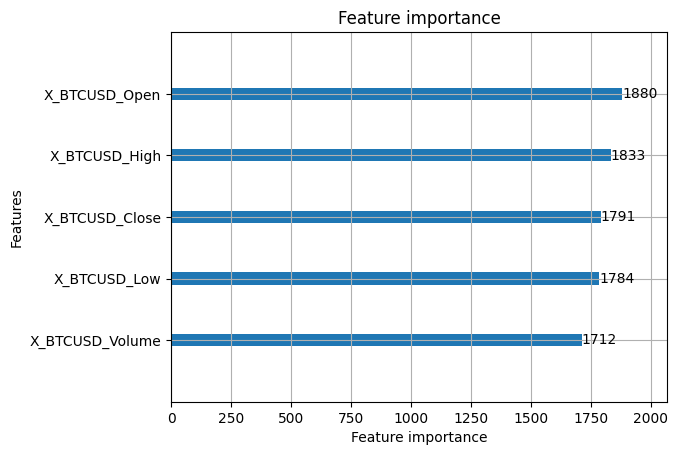

In [2339]:
lgb.plot_importance(lgb_model)

### Train Test Split

In [2786]:
backtest_data = df_returns.copy()
backtest_data['Open'] = data['X_BTCUSD_Open']
backtest_data['High'] = data['X_BTCUSD_High']
backtest_data['Low'] = data['X_BTCUSD_Low']
backtest_data['Close'] = data['X_BTCUSD_Close']
backtest_data['Volume'] = data['X_BTCUSD_Volume']

mapping = dict(enumerate(c.cat.categories)) # mapping of code to label
print("Mapping of Code to Label\n", mapping)

backtest_data

Mapping of Code to Label
 {0: 'Sell', 1: 'Hold', 2: 'Buy'}


,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1,Open,High,Low,Close,Volume
2013-10-07,0.013197,0.013197,0.013197,0.013197,0.000000,1,123.61000,123.61000,123.61,123.61,0.100000
2013-10-08,0.002427,0.004692,0.002346,0.004611,38.916000,1,123.91000,124.19000,123.90,124.18,3.991600
2013-10-09,0.000862,-0.001394,-0.000484,-0.002738,-0.292765,1,124.01687,124.01687,123.84,123.84,2.823000
2013-10-10,0.014781,0.014862,0.016231,0.016311,-0.291534,1,125.85000,125.86000,125.85,125.86,2.000000
2013-10-11,0.000000,0.000000,0.000000,0.000000,0.000000,1,125.85000,125.86000,125.85,125.86,2.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-25,0.006202,0.002531,0.007607,0.012437,-0.627109,0,21221.60000,21589.00000,20888.80,21474.50,1835.570691
2022-06-26,0.012025,0.012877,0.003265,-0.021011,0.042287,1,21476.80000,21867.00000,20957.00,21023.30,1913.190977
2022-06-27,-0.021111,-0.015471,-0.021544,-0.014603,1.077073,0,21023.40000,21528.70000,20505.50,20716.30,3973.836377
2022-06-28,-0.014608,-0.015802,-0.016591,-0.022432,-0.182016,1,20716.30000,21188.50000,20165.30,20251.60,3250.533589


### LGBM Backtest

In [2787]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

class LGBStrategy(Strategy):
    price_delta = .004  # 0.4%
    
    def init(self):
        self.clf = lgb_model
        
        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return
    
        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        X = get_X(self.data.df.iloc[-1:])

        forecast = self.clf.predict(scaler.transform(X))[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        
        if forecast == 2 and not self.position.is_long:
            self.buy(size=1)
        elif forecast == 0 and self.position.is_long:
            self.sell(size=1)

bt = Backtest(backtest_data.copy(), LGBStrategy, cash=100000, commission=.0002, margin=0.05)
stats = bt.run()
stats

Start                     2013-10-07 00:00:00
End                       2022-06-29 00:00:00
Duration                   3187 days 00:00:00
Exposure Time [%]                   14.648683
Equity Final [$]                 140290.00254
Equity Peak [$]                  153120.90254
Return [%]                          40.290003
Buy & Hold Return [%]            16149.656177
Return (Ann.) [%]                    3.952122
Volatility (Ann.) [%]                7.305734
Sharpe Ratio                         0.540962
Sortino Ratio                        0.871681
Calmar Ratio                         0.339481
Max. Drawdown [%]                  -11.641668
Avg. Drawdown [%]                   -1.611498
Max. Drawdown Duration      181 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                   44
Win Rate [%]                             75.0
Best Trade [%]                      27.953791
Worst Trade [%]                    -35.667609
Avg. Trade [%]                    

In [2788]:
bt.plot()

Row(id='116484', ...)

### LGBM Walk Forward Backtest

In [2343]:
def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

def get_training_data(df):
    X = get_X(df)
    df_tmp = X.pct_change()
    df_tmp['y_Close_t+1'] = get_y(df)
    df_tmp.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_tmp.dropna(inplace=True)
    X = get_X(df_tmp)
    y = get_y(df_tmp).values.ravel()
    return X, y

class LGBWalkForwardStrategy(LGBStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 30:
            return super().next()

        # Retrain on last N_TRAIN values
        # df = self.data.df[-N_TRAIN:]
        # X, y = get_clean_Xy(df)
        # self.clf.fit(X, y)
        df = self.data.df[-N_TRAIN:]
        X, y = get_training_data(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(backtest_data.copy(), LGBWalkForwardStrategy, cash=100000, commission=.0002, margin=.05)
bt.run()

Start                     2013-10-07 00:00:00
End                       2022-06-29 00:00:00
Duration                   3187 days 00:00:00
Exposure Time [%]                   26.537014
Equity Final [$]                  111479.9892
Equity Peak [$]                   158787.2892
Return [%]                          11.479989
Buy & Hold Return [%]            16149.656177
Return (Ann.) [%]                    1.252012
Volatility (Ann.) [%]               10.599331
Sharpe Ratio                         0.118122
Sortino Ratio                        0.169757
Calmar Ratio                         0.040898
Max. Drawdown [%]                  -30.613156
Avg. Drawdown [%]                   -3.135383
Max. Drawdown Duration      233 days 00:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                     155.368835
Worst Trade [%]                    -10.358979
Avg. Trade [%]                    

In [2344]:
bt.plot()

Row(id='83694', ...)

### Case Based Reasoner Backtest

In [2345]:
class CaseBasedReasoningAgent:
    """
    In this agent, we need to store the data for each time epoch for the case
    based reasoning agent to run the kNN algorithm on to find the cluster in
    history that best represents the current moment in time when a new price
    comes in.
    """
    
    """
    fit_transform vs transform
    
    fit_transform learns the mean and variance of the data passed into it. This
    is usually the training data and once the mean and variance is calculated, 
    they are used to transform the data to 0 mean and variance as 1.
    
    If we call fit_transform on our testing data as well, then we would fit the
    transformation using the parameters (mean and variance) of our testing data
    set. This shouldn't be done because we should not know our test data ahead of
    time. Hence, we only call transform on the data, which uses the mean and 
    variance fitted on the training data previously.
    
    """

    def __init__(self, data, scaler, n_clusters):
        self._kmeans_model = None
        self._scaler = scaler
        self._data = data # note: model should only have training data
        self._cluster_count = n_clusters
        
        
    def get_X(self):
        """
        All features are labelled with a prefix X
        """
        return self._data.filter(like="X_")
    
    def get_y(self):
        """
        Dependent variable has a prefix y_
        """
        return self._data.filter(like="y_")

    def train_model(self):
        df_X = self.get_X()

        self._kmeans_model = KMeans(n_clusters=self._cluster_count, init="k-means++")
        self._kmeans_model.fit(df_X.values)
        df = self._data.copy()
        df.loc[:, "labels"] = self._kmeans_model.labels_
        self._data = df

    def get_prediction(self, bar):
        transformed_bar = self._scaler.transform(bar)
        cluster_prediction = self._kmeans_model.predict(transformed_bar)
        # cluster_prediction = self._kmeans_model.predict(bar)
        return cluster_prediction[0] # returns a list of 1 value hence [0]
    
    def get_cluster(self, cluster_number):
        df_current_predictors = self._data.loc[
            self._data["labels"] == cluster_number
        ]
        return df_current_predictors
    
    def get_related_epochs(self, bar):
        cluster_number = self.get_prediction(bar)
        epochs_in_cluster = self.get_cluster(cluster_number)
        return epochs_in_cluster
    
    @staticmethod
    def euclideanDistance(data1, data2, length):
        """
        Produces the euclidean distances for two iterable objects of equal length

        Args:
            data1 (Iterable(int) | Iterable(float)): A sequence of data for a feature
            data2 (Iterable(int) | Iterable(float)): A sequence of data for a feature
            length (int): Length of the sequence of data of the feature

        Returns:
            np.array: The euclidean distances of the array-like inputs in a NumPy array
        """
        distance = 0
        for x in range(length):
            distance += np.square(data1[x] - data2[x])
        return np.sqrt(distance)

    @staticmethod
    def move_column_inplace(df, col, pos):
        """
        Helper function for moving column positions in pandas
        """
        col = df.pop(col)
        df.insert(pos, col.name, col)

#### CBR Backtest (2 Clusters)

In [2346]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(backtest_data.copy(), scaler, 2)
cbr.train_model()

In [2347]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return False
        elif val < lower:
            return True
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            # print(self.features.iloc[self.features.index.get_loc(current_idx)-1: self.features.index.get_loc(current_idx), :])

            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats = bt.run()
stats

Start                     2013-10-07 00:00:00
End                       2022-06-29 00:00:00
Duration                   3187 days 00:00:00
Exposure Time [%]                   17.095358
Equity Final [$]                 136241.54834
Equity Peak [$]                  149534.29386
Return [%]                          36.241548
Buy & Hold Return [%]            16149.656177
Return (Ann.) [%]                    3.604197
Volatility (Ann.) [%]                7.891444
Sharpe Ratio                         0.456722
Sortino Ratio                        0.691525
Calmar Ratio                         0.217006
Max. Drawdown [%]                  -16.608742
Avg. Drawdown [%]                   -1.821434
Max. Drawdown Duration      240 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                   40
Win Rate [%]                             27.5
Best Trade [%]                     181.985151
Worst Trade [%]                    -12.795237
Avg. Trade [%]                    

In [2348]:
bt.plot()

Row(id='85303', ...)

#### CBR Backtest (3 Clusters)

In [2705]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(backtest_data.copy(), scaler, 3)
cbr.train_model()

In [2706]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return False
        elif val < lower:
            return True
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            # print(self.features.iloc[self.features.index.get_loc(current_idx)-1: self.features.index.get_loc(current_idx), :])

            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats = bt.run()
stats

Start                     2013-10-07 00:00:00
End                       2022-06-29 00:00:00
Duration                   3187 days 00:00:00
Exposure Time [%]                   16.185696
Equity Final [$]                 136599.87292
Equity Peak [$]                  148296.30844
Return [%]                          36.599873
Buy & Hold Return [%]            16149.656177
Return (Ann.) [%]                    3.635359
Volatility (Ann.) [%]                7.627271
Sharpe Ratio                         0.476626
Sortino Ratio                        0.723769
Calmar Ratio                          0.22237
Max. Drawdown [%]                  -16.348246
Avg. Drawdown [%]                    -1.59775
Max. Drawdown Duration      233 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                   54
Win Rate [%]                        42.592593
Best Trade [%]                      55.904267
Worst Trade [%]                    -16.446839
Avg. Trade [%]                    

In [2707]:
bt.plot()

Row(id='110243', ...)

#### CBR Backtest (4 Clusters)

In [2352]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(backtest_data.copy(), scaler, 4)
cbr.train_model()

In [2353]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return True
        elif val < lower:
            return False
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            # print(self.features.iloc[self.features.index.get_loc(current_idx)-1: self.features.index.get_loc(current_idx), :])

            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats = bt.run()
stats

Start                     2013-10-07 00:00:00
End                       2022-06-29 00:00:00
Duration                   3187 days 00:00:00
Exposure Time [%]                   17.095358
Equity Final [$]                 136241.54834
Equity Peak [$]                  149534.29386
Return [%]                          36.241548
Buy & Hold Return [%]            16149.656177
Return (Ann.) [%]                    3.604197
Volatility (Ann.) [%]                7.891444
Sharpe Ratio                         0.456722
Sortino Ratio                        0.691525
Calmar Ratio                         0.217006
Max. Drawdown [%]                  -16.608742
Avg. Drawdown [%]                   -1.821434
Max. Drawdown Duration      240 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                   40
Win Rate [%]                             27.5
Best Trade [%]                     181.985151
Worst Trade [%]                    -12.795237
Avg. Trade [%]                    

In [2354]:
bt.plot()

Row(id='88989', ...)

## Include Feature Engineering

### Train Test Split

In [2708]:
pre_split_data = feature_engineering_data.copy()

pre_split_data['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10).pct_change()
pre_split_data['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30).pct_change()
pre_split_data['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200).pct_change()
pre_split_data['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10).pct_change()
pre_split_data['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30).pct_change()
pre_split_data['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200).pct_change()
pre_split_data['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
pre_split_data['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
pre_split_data['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
pre_split_data['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10).pct_change()
pre_split_data['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30).pct_change()
pre_split_data['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200).pct_change()

# pre_split_data['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10)
# pre_split_data['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30)
# pre_split_data['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200)
# pre_split_data['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10)
# pre_split_data['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30)
# pre_split_data['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200)
# pre_split_data['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
# pre_split_data['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
# pre_split_data['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
# pre_split_data['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10)
# pre_split_data['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30)
# pre_split_data['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200)

pre_split_data.replace([np.inf, -np.inf], np.nan, inplace=True)
pre_split_data.dropna(inplace=True)
X = pre_split_data.filter(like="X_") # all features are labelled with a prefix X_
y = pre_split_data.filter(like="y_") # dependent variable has a prefix y_
# Get index to split into Training and Test proportion set
split_idx = int(len(X) * TRAIN_PROPORTION)

# Partition dataset into Training and Test Data partitions
X_train = X.iloc[:split_idx, :]
y_train = y.iloc[:split_idx, :]

X_test = X.iloc[split_idx:, :]
y_test = y.iloc[split_idx:, :]

### Scale features (MinMaxScaler)

In [2709]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [2495]:
tscv = TimeSeriesSplit()
lgbm_fe = lgb.LGBMClassifier(objective='multiclass')

In [2496]:
scores = cross_val_score(lgbm_fe, X_train, y_train.values.ravel(), cv=tscv, scoring='accuracy')
print("Accuracy: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Accuracy: 0.566 (+/- 0.107)


In [2497]:
start = time.time()
print("Starting model.fit \n")
lgbm_fe.fit(X_train, y_train.values.ravel())
print(f'Time to fit: {time.time() - start}')
start = time.time()

print("Starting model.predict \n")
predicted_y = lgbm_fe.predict(X_test)
print(f'Time to predict: {time.time() - start}')

print("LGB Score: ", lgbm_fe.score(X_test, y_test))
accuracy = accuracy_score(predicted_y, y_test)
print("Accuracy: %.3f" % accuracy)

Starting model.fit 

Time to fit: 3.4325051307678223
Starting model.predict 

Time to predict: 0.007302999496459961
LGB Score:  0.5282112845138055
Accuracy: 0.528


In [2498]:
f1_score(y_test, predicted_y, average=None)

array([0.17712177, 0.68165468, 0.2614841 ])

In [2499]:
f1_score(y_test, predicted_y, average="micro")

0.5282112845138055

In [2500]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_y)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 24 147  19]
 [ 37 379  46]
 [ 20 124  37]]


In [2501]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lgbm_fe.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgbm_fe.score(X_test, y_test)))

Training set score: 0.9995
Test set score: 0.5282


In [2502]:
print(classification_report(y_test, predicted_y, target_names=d.values()))

              precision    recall  f1-score   support

        Sell       0.30      0.13      0.18       190
        Hold       0.58      0.82      0.68       462
         Buy       0.36      0.20      0.26       181

    accuracy                           0.53       833
   macro avg       0.41      0.38      0.37       833
weighted avg       0.47      0.53      0.48       833



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

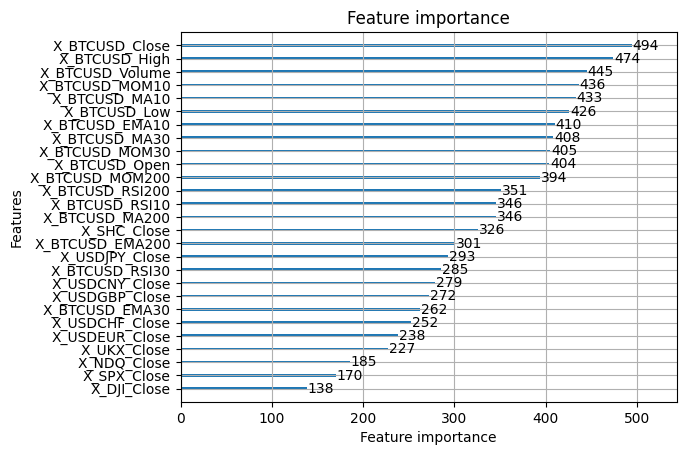

In [2503]:
lgb.plot_importance(lgbm_fe)

### Grid Search Hyperparameters Tuning

In [ ]:
# parameter definition
parameters = {'num_leaves':[10,20], # default 31
              'num_iterations': [50,150],
              'min_child_samples':[20,50], # default 20 -- indicates the min number of data required in a child (leaf)
              'max_depth':[4,5,6,7,8], # default -1 -- maximum tree depth for base learners
              'colsample_bytree': [0.6,0.8,1], # default 1, range (0,1)
              'learning_rate': [0.01, 0.05],
              'boosting': ['dart','gbdt']
             }

In [ ]:
# scoring for GridSearchCV
lgbm=lgb.LGBMClassifier(objective='multiclass')
clf=GridSearchCV(lgbm,parameters,scoring='accuracy')
clf.fit(X=X_train, y=y_train.values.ravel())
print(clf.best_params_)
predicted=clf.predict(X_test)
print('Classification of the result is:')
print(accuracy_score(y_test, predicted))
end = time.time()
print('Execution time is:')
print(end - start)

In [157]:
# start = time.time()
# lgbm=lgb.LGBMClassifier("multiclass")
# parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20]}
# clf=RandomizedSearchCV(lgbm,parameters,scoring='accuracy',n_iter=60)
# clf.fit(X=X_train, y=y_train.values.ravel())
# print(clf.best_params_)
# predicted=clf.predict(X_test)
# print('Classification of the result is:')
# print(accuracy_score(y_test, predicted))
# end = time.time()
# print('Execution time is:')
# print(end - start)

### After Hyperparameter Tuning

In [2504]:
tscv = TimeSeriesSplit()
# lgbm_fe = lgb.LGBMClassifier(objective='multiclass', num_leaves=10, min_child_samples=800, colsample_bytree=0.2)
lgbm_fe_tuned = lgb.LGBMClassifier(boosting_type='dart', num_leaves=10, max_depth=4, n_estimators=50, objective='multiclass', colsample_bytree=0.6)

In [2505]:
scores = cross_val_score(lgbm_fe_tuned, X_train, y_train.values.ravel(), cv=tscv, scoring='accuracy')
print("Accuracy: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Accuracy: 0.586 (+/- 0.115)


In [2506]:
start = time.time()
print("Starting model.fit \n")
lgbm_fe_tuned.fit(X_train, y_train.values.ravel())
print(f'Time to fit: {time.time() - start}')
start = time.time()

print("Starting model.predict \n")
predicted_y = lgbm_fe_tuned.predict(X_test)
print(f'Time to predict: {time.time() - start}')

print("LGB Score: ", lgbm_fe_tuned.score(X_test, y_test))
accuracy = accuracy_score(predicted_y, y_test)
print("Accuracy: %.3f" % accuracy)

Starting model.fit 

Time to fit: 0.6221370697021484
Starting model.predict 

Time to predict: 0.0016620159149169922
LGB Score:  0.5474189675870348
Accuracy: 0.547


In [2507]:
f1_score(y_test, predicted_y, average=None)

array([0.11403509, 0.69822485, 0.23529412])

In [2508]:
f1_score(y_test, predicted_y, average="micro")

0.5474189675870348

In [2509]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_y)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 13 164  13]
 [ 18 413  31]
 [  7 144  30]]


In [2510]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lgbm_fe_tuned.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgbm_fe_tuned.score(X_test, y_test)))

Training set score: 0.7249
Test set score: 0.5474


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

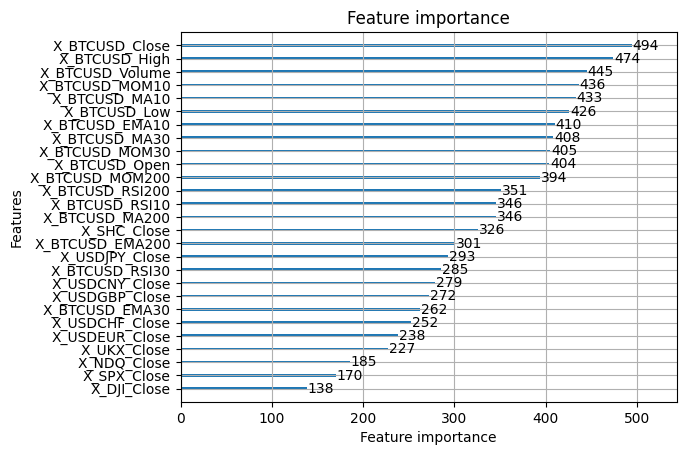

In [2511]:
lgb.plot_importance(lgbm_fe)

### Prepare Backtesting Data

In [2463]:
# feature_engineering_data['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10).pct_change()
# feature_engineering_data['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30).pct_change()
# feature_engineering_data['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200).pct_change()
# feature_engineering_data['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10).pct_change()
# feature_engineering_data['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30).pct_change()
# feature_engineering_data['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200).pct_change()
# feature_engineering_data['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
# feature_engineering_data['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
# feature_engineering_data['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
# feature_engineering_data['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10).pct_change()
# feature_engineering_data['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30).pct_change()
# feature_engineering_data['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200).pct_change()

In [2710]:
backtest_data = pre_split_data.copy()
backtest_data['Open'] = data['X_BTCUSD_Open']
backtest_data['High'] = data['X_BTCUSD_High']
backtest_data['Low'] = data['X_BTCUSD_Low']
backtest_data['Close'] = data['X_BTCUSD_Close']
backtest_data['Volume'] = data['X_BTCUSD_Volume']
backtest_data = backtest_data.copy()
mapping = dict(enumerate(c.cat.categories)) # mapping of code to label
print("Mapping of Code to Label\n", mapping)

backtest_data

Mapping of Code to Label
 {0: 'Sell', 1: 'Hold', 2: 'Buy'}


,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1,X_BTCUSD_MA10,X_BTCUSD_MA30,X_BTCUSD_MA200,X_BTCUSD_EMA10,...,X_USDGBP_Close,X_USDCNY_Close,X_USDJPY_Close,X_USDEUR_Close,X_USDCHF_Close,Open,High,Low,Close,Volume
2014-11-25,0.054027,0.012987,0.016216,0.010753,-0.098601,1,-0.001064,0.001244,-0.000749,0.001628,...,-0.000314,-0.000847,-0.003440,-0.002738,-0.002658,389.99000,390.00000,376.00000,376.00000,10.132409
2014-11-26,-0.046129,-0.000144,-0.025476,-0.008317,0.898627,1,-0.001902,0.000789,-0.000825,-0.000194,...,-0.005657,0.000424,-0.002612,-0.002620,-0.003122,372.00000,389.94381,366.42120,372.87268,19.237670
2014-11-27,0.036795,-0.010915,-0.003839,0.010803,-0.876188,2,-0.006176,0.001083,-0.000650,0.001804,...,0.004741,0.000000,0.002424,0.003628,0.003714,385.68775,385.68775,365.01441,376.90071,2.381852
2014-11-28,-0.014747,0.003402,-0.012304,0.026796,8.771119,0,0.003222,0.004772,-0.000542,0.006385,...,0.004718,0.000668,0.006362,0.000748,-0.000736,380.00000,387.00000,360.52323,387.00000,23.273363
2014-11-29,0.018418,0.000000,0.051486,-0.020452,-0.819585,1,-0.002926,0.003024,-0.000621,0.001366,...,0.000000,0.000000,0.000000,0.000000,0.000000,386.99900,387.00000,379.08519,379.08519,4.198861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-25,0.006202,0.002531,0.007607,0.012437,-0.627109,0,-0.005258,-0.009799,-0.003760,-0.000282,...,0.000000,0.000000,0.000000,0.000000,0.000000,21221.60000,21589.00000,20888.80000,21474.50000,1835.570691
2022-06-26,0.012025,0.012877,0.003265,-0.021011,0.042287,1,0.003201,-0.009696,-0.003815,-0.004046,...,0.000000,0.000000,0.000000,0.000000,0.000000,21476.80000,21867.00000,20957.00000,21023.30000,1913.190977
2022-06-27,-0.021111,-0.015471,-0.021544,-0.014603,1.077073,0,0.001376,-0.010759,-0.003488,-0.005930,...,0.000025,0.000239,0.001960,-0.002640,-0.001066,21023.40000,21528.70000,20505.50000,20716.30000,3973.836377
2022-06-28,-0.014608,-0.015802,-0.016591,-0.022432,-0.182016,1,0.006312,-0.012049,-0.003514,-0.008850,...,0.007006,0.002631,0.005073,0.005823,0.000774,20716.30000,21188.50000,20165.30000,20251.60000,3250.533589


### LGB Backtest (without Tuning)

In [2513]:
N_TRAIN = split_idx

def get_X(data):
        """
        Method assumes that columns for independent variables X are all columns of
        the dataframe excluding the last column of the dataframe.
        """
        return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    """
    Method assumes that column for dependent variable y is the last column
    of the dataframe.
    """
    return data.filter(like="y_") # dependent variable has a prefix y_

class LGBStrategy(Strategy):
    price_delta = .004  # 0.4%
    
    def init(self):
        self.clf = lgbm_fe
        
        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return
    
        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        X = scaler.transform(get_X(self.data.df.iloc[-1:]))

        forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
    
        # if forecast != 1: 
        #     print(self.data.df.index[-1], forecast)
        if forecast == 2 and not self.position.is_long:
            self.buy(size=1)
        elif forecast == 0 and self.position.is_long:
            self.sell(size=1)

bt = Backtest(backtest_data.copy(), LGBStrategy, cash=100000, commission=.0002, margin=0.05)
bt.run()

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   16.762797
Equity Final [$]                  138839.6919
Equity Peak [$]                   146184.8663
Return [%]                          38.839692
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    4.412332
Volatility (Ann.) [%]                7.744265
Sharpe Ratio                         0.569755
Sortino Ratio                        0.942441
Calmar Ratio                          0.29588
Max. Drawdown [%]                   -14.91258
Avg. Drawdown [%]                   -1.194828
Max. Drawdown Duration      473 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                   38
Win Rate [%]                        73.684211
Best Trade [%]                      41.267275
Worst Trade [%]                    -25.745771
Avg. Trade [%]                    

In [2514]:
bt.plot()

Row(id='93389', ...)

### LGB Backtest (with Tuning)

In [2517]:
N_TRAIN = split_idx

def get_X(data):
        """
        Method assumes that columns for independent variables X are all columns of
        the dataframe excluding the last column of the dataframe.
        """
        return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    """
    Method assumes that column for dependent variable y is the last column
    of the dataframe.
    """
    return data.filter(like="y_") # dependent variable has a prefix y_

class LGBStrategy(Strategy):
    price_delta = .004  # 0.4%
    
    def init(self):
        self.clf = lgbm_fe_tuned
        
        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return
    
        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        X = scaler.transform(get_X(self.data.df.iloc[-1:]))

        forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
    
        # if forecast != 1: 
        #     print(self.data.df.index[-1], forecast)
        if forecast == 2 and not self.position.is_long:
            self.buy(size=1)
        elif forecast == 0 and self.position.is_long:
            self.sell(size=1)

bt_tuned = Backtest(backtest_data.copy(), LGBStrategy, cash=100000, commission=.0002, margin=0.05)
bt_tuned.run()

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   14.924297
Equity Final [$]                 103188.18868
Equity Peak [$]                  138965.30632
Return [%]                           3.188189
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    0.413804
Volatility (Ann.) [%]                9.232081
Sharpe Ratio                         0.044822
Sortino Ratio                        0.064405
Calmar Ratio                          0.01532
Max. Drawdown [%]                  -27.010639
Avg. Drawdown [%]                   -1.936369
Max. Drawdown Duration      493 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                   19
Win Rate [%]                        63.157895
Best Trade [%]                      92.908461
Worst Trade [%]                    -33.047786
Avg. Trade [%]                    

In [2519]:
bt_tuned.plot()

Row(id='97553', ...)

In [670]:
# # histograms
# backtest_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
# plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

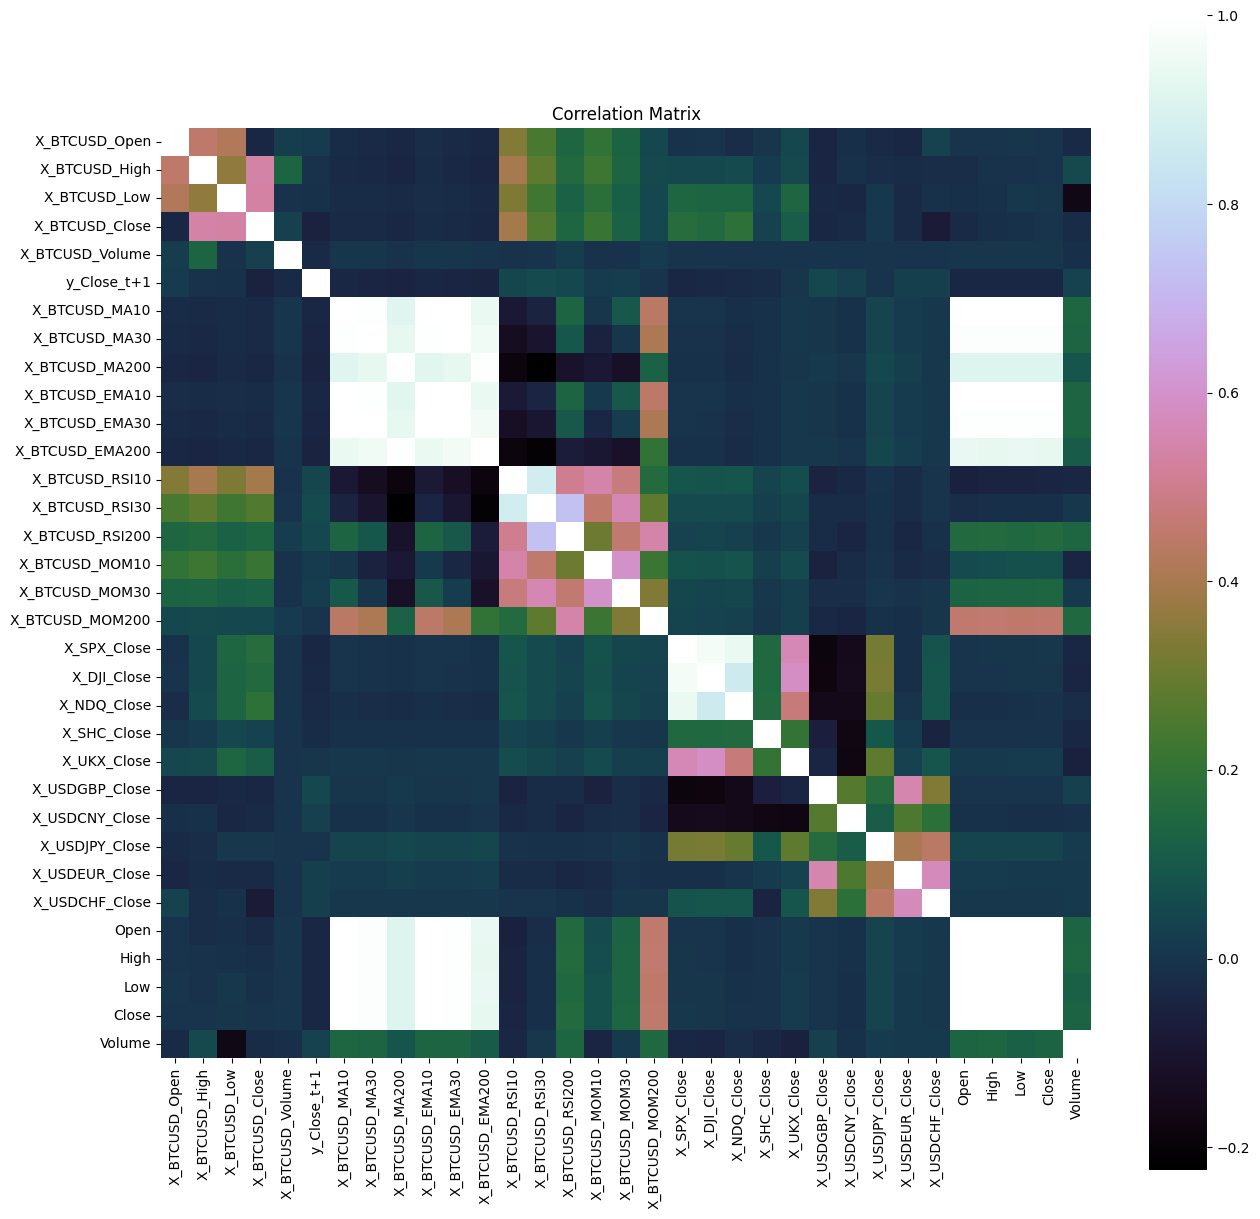

In [1184]:
# correlation
correlation = backtest_data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=False,cmap='cubehelix')

In [ ]:
class CaseBasedReasoningAgent:
    """
    In this agent, we need to store the data for each time epoch for the case
    based reasoning agent to run the kNN algorithm on to find the cluster in
    history that best represents the current moment in time when a new price
    comes in.
    """
    
    """
    fit_transform vs transform
    
    fit_transform learns the mean and variance of the data passed into it. This
    is usually the training data and once the mean and variance is calculated, 
    they are used to transform the data to 0 mean and variance as 1.
    
    If we call fit_transform on our testing data as well, then we would fit the
    transformation using the parameters (mean and variance) of our testing data
    set. This shouldn't be done because we should not know our test data ahead of
    time. Hence, we only call transform on the data, which uses the mean and 
    variance fitted on the training data previously.
    
    """

    def __init__(self, data, scaler, n_clusters):
        self._kmeans_model = None
        self._scaler = scaler
        self._data = data # note: model should only have training data
        self._cluster_count = n_clusters
        
        
    def get_X(self):
        """
        All features are labelled with a prefix X
        """
        return self._data.filter(like="X_")
    
    def get_y(self):
        """
        Dependent variable has a prefix y_
        """
        return self._data.filter(like="y_")

    def train_model(self):
        df_X = self.get_X()

        self._kmeans_model = KMeans(n_clusters=self._cluster_count, init="k-means++")
        self._kmeans_model.fit(df_X.values)
        df = self._data.copy()
        df.loc[:, "labels"] = self._kmeans_model.labels_
        self._data = df

    def get_prediction(self, bar):
        transformed_bar = self._scaler.transform(bar)
        cluster_prediction = self._kmeans_model.predict(transformed_bar)
        return cluster_prediction[0] # returns a list of 1 value hence [0]
    
    def get_cluster(self, cluster_number):
        df_current_predictors = self._data.loc[
            self._data["labels"] == cluster_number
        ]
        return df_current_predictors
    
    def get_related_epochs(self, bar):
        cluster_number = self.get_prediction(bar)
        epochs_in_cluster = self.get_cluster(cluster_number)
        return epochs_in_cluster
    
    @staticmethod
    def euclideanDistance(data1, data2, length):
        """
        Produces the euclidean distances for two iterable objects of equal length

        Args:
            data1 (Iterable(int) | Iterable(float)): A sequence of data for a feature
            data2 (Iterable(int) | Iterable(float)): A sequence of data for a feature
            length (int): Length of the sequence of data of the feature

        Returns:
            np.array: The euclidean distances of the array-like inputs in a NumPy array
        """
        distance = 0
        for x in range(length):
            distance += np.square(data1[x] - data2[x])
        return np.sqrt(distance)

    @staticmethod
    def move_column_inplace(df, col, pos):
        """
        Helper function for moving column positions in pandas
        """
        col = df.pop(col)
        df.insert(pos, col.name, col)

### Case Based Reasoner (2 clusters)

In [2520]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(pre_split_data.iloc[:split_idx,:].copy(), scaler, 2)
cbr.train_model()

In [2521]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return True
        elif val < lower:
            return False
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            # print(get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1'])
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        # print(X)
        # transformed_input = self.clf._scaler.transform(X.values.reshape(1,-1))
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
#         forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        # print(forecast)
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt_fe_cbr_2 = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats_fe_cbr_2 = bt_fe_cbr_2.run()
# stats

In [2522]:
bt_fe_cbr_2.plot()

Row(id='99162', ...)

In [2523]:
stats_fe_cbr_2

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   17.555876
Equity Final [$]                 134633.39368
Equity Peak [$]                   147926.1392
Return [%]                          34.633394
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    3.990529
Volatility (Ann.) [%]                8.568043
Sharpe Ratio                         0.465746
Sortino Ratio                        0.707537
Calmar Ratio                         0.237605
Max. Drawdown [%]                  -16.794826
Avg. Drawdown [%]                   -2.215689
Max. Drawdown Duration      240 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                   37
Win Rate [%]                        27.027027
Best Trade [%]                     181.985151
Worst Trade [%]                    -12.795237
Avg. Trade [%]                    

### Case Based Reasoner (3 clusters)

In [2711]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(pre_split_data.iloc[:split_idx,:].copy(), scaler, 3)
cbr.train_model()

In [2712]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return False
        elif val < lower:
            return True
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            # print(get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1'])
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        # print(X)
        # transformed_input = self.clf._scaler.transform(X.values.reshape(1,-1))
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
#         forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        # print(forecast)
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt_fe_cbr_3 = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats_fe_cbr_3 = bt_fe_cbr_3.run()
# stats

In [2713]:
bt_fe_cbr_3.plot()

Row(id='112086', ...)

In [2714]:
stats_fe_cbr_3

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   16.438356
Equity Final [$]                 134212.48826
Equity Peak [$]                  145908.92378
Return [%]                          34.212488
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    3.947694
Volatility (Ann.) [%]                8.318697
Sharpe Ratio                         0.474557
Sortino Ratio                        0.722139
Calmar Ratio                          0.23745
Max. Drawdown [%]                  -16.625399
Avg. Drawdown [%]                   -2.051785
Max. Drawdown Duration      233 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                   50
Win Rate [%]                             42.0
Best Trade [%]                      55.904267
Worst Trade [%]                    -16.446839
Avg. Trade [%]                    

### Case Based Reasoner (4 clusters)

In [2528]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(pre_split_data.iloc[:split_idx,:].copy(), scaler, 4)
cbr.train_model()

In [2529]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return True
        elif val < lower:
            return False
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            # print(get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1'])
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        # print(X)
        # transformed_input = self.clf._scaler.transform(X.values.reshape(1,-1))
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
#         forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        # print(forecast)
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt_fe_cbr_4 = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats_fe_cbr_4 = bt_fe_cbr_4.run()
# stats

In [2531]:
bt_fe_cbr_4.plot()

Row(id='102848', ...)

In [2532]:
stats_fe_cbr_4

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   17.555876
Equity Final [$]                 134633.39368
Equity Peak [$]                   147926.1392
Return [%]                          34.633394
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    3.990529
Volatility (Ann.) [%]                8.568043
Sharpe Ratio                         0.465746
Sortino Ratio                        0.707537
Calmar Ratio                         0.237605
Max. Drawdown [%]                  -16.794826
Avg. Drawdown [%]                   -2.215689
Max. Drawdown Duration      240 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                   37
Win Rate [%]                        27.027027
Best Trade [%]                     181.985151
Worst Trade [%]                    -12.795237
Avg. Trade [%]                    

### PCA data

In [2751]:
pca_15 = PCA(n_components=15)

In [2752]:
pca_15.fit(standard_data_scaled)

PCA(n_components=15)

In [2753]:
pca_backtest_data = feature_engineering_data.copy()

pca_backtest_data['X_BTCUSD_MA10'] = MA(data, 'X_BTCUSD_Close', 10).pct_change()
pca_backtest_data['X_BTCUSD_MA30'] = MA(data, 'X_BTCUSD_Close', 30).pct_change()
pca_backtest_data['X_BTCUSD_MA200'] = MA(data, 'X_BTCUSD_Close', 200).pct_change()
pca_backtest_data['X_BTCUSD_EMA10'] = EMA(data, 'X_BTCUSD_Close', 10).pct_change()
pca_backtest_data['X_BTCUSD_EMA30'] = EMA(data, 'X_BTCUSD_Close', 30).pct_change()
pca_backtest_data['X_BTCUSD_EMA200'] = EMA(data, 'X_BTCUSD_Close', 200).pct_change()
pca_backtest_data['X_BTCUSD_RSI10'] = RSI(data['X_BTCUSD_Close'], 10)
pca_backtest_data['X_BTCUSD_RSI30'] = RSI(data['X_BTCUSD_Close'], 30)
pca_backtest_data['X_BTCUSD_RSI200'] = RSI(data['X_BTCUSD_Close'], 200)
pca_backtest_data['X_BTCUSD_MOM10'] = MOM(data['X_BTCUSD_Close'], 10).pct_change()
pca_backtest_data['X_BTCUSD_MOM30'] = MOM(data['X_BTCUSD_Close'], 30).pct_change()
pca_backtest_data['X_BTCUSD_MOM200'] = MOM(data['X_BTCUSD_Close'], 200).pct_change()

pca_backtest_data.replace([np.inf, -np.inf], np.nan, inplace=True)
pca_backtest_data.dropna(inplace=True)
X = pca_backtest_data.filter(like="X_") # all features are labelled with a prefix X_
y = pca_backtest_data.filter(like="y_") # dependent variable has a prefix y_
# Get index to split into Training and Test proportion set
split_idx = int(len(X) * TRAIN_PROPORTION)

# Partition dataset into Training and Test Data partitions
X_train = X.iloc[:split_idx, :]
y_train = y.iloc[:split_idx, :]

X_test = X.iloc[split_idx:, :]
y_test = y.iloc[split_idx:, :]

### Scale features (PCA_Scaler)

In [2754]:
scaler = pca_scaler
# scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [2755]:
tscv = TimeSeriesSplit()
lgbm_fe = lgb.LGBMClassifier(objective='multiclass')

In [2756]:
scores = cross_val_score(lgbm_fe, pca_15.transform(X_train), y_train.values.ravel(), cv=tscv, scoring='accuracy')
print("Accuracy: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Accuracy: 0.564 (+/- 0.101)


In [2757]:
start = time.time()
print("Starting model.fit \n")
lgbm_fe.fit(pca_15.transform(X_train), y_train.values.ravel())
print(f'Time to fit: {time.time() - start}')
start = time.time()

print("Starting model.predict \n")
predicted_y = lgbm_fe.predict(pca_15.transform(X_test))
print(f'Time to predict: {time.time() - start}')

print("LGB Score: ", lgbm_fe.score(pca_15.transform(X_test), y_test))
accuracy = accuracy_score(predicted_y, y_test)
print("Accuracy: %.3f" % accuracy)

Starting model.fit 

Time to fit: 2.6989781856536865
Starting model.predict 

Time to predict: 0.03221583366394043
LGB Score:  0.5102040816326531
Accuracy: 0.510


In [2758]:
f1_score(y_test, predicted_y, average=None)

array([0.1533101 , 0.67921147, 0.18250951])

In [2759]:
f1_score(y_test, predicted_y, average="micro")

0.5102040816326531

In [2760]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_y)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 22 146  22]
 [ 47 379  36]
 [ 28 129  24]]


In [2761]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lgbm_fe.score(pca_15.transform(X_train), y_train)))

print('Test set score: {:.4f}'.format(lgbm_fe.score(pca_15.transform(X_test), y_test)))

Training set score: 0.9995
Test set score: 0.5102


In [2762]:
print(classification_report(y_test, predicted_y, target_names=d.values()))

              precision    recall  f1-score   support

        Sell       0.23      0.12      0.15       190
        Hold       0.58      0.82      0.68       462
         Buy       0.29      0.13      0.18       181

    accuracy                           0.51       833
   macro avg       0.37      0.36      0.34       833
weighted avg       0.44      0.51      0.45       833



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

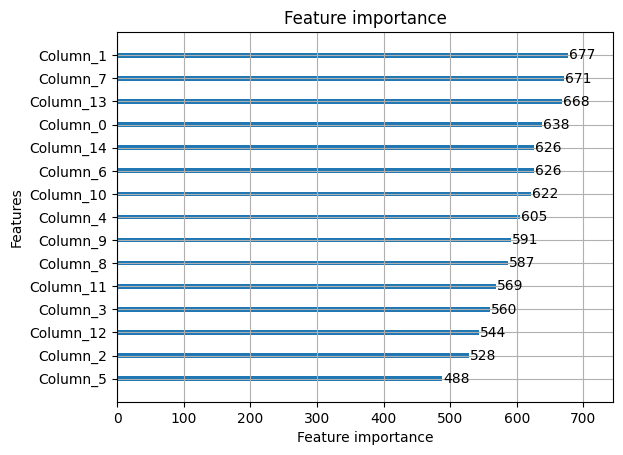

In [2763]:
lgb.plot_importance(lgbm_fe)

In [2764]:
backtest_data = pca_backtest_data.copy()
backtest_data['Open'] = data['X_BTCUSD_Open']
backtest_data['High'] = data['X_BTCUSD_High']
backtest_data['Low'] = data['X_BTCUSD_Low']
backtest_data['Close'] = data['X_BTCUSD_Close']
backtest_data['Volume'] = data['X_BTCUSD_Volume']
backtest_data = backtest_data.copy()
mapping = dict(enumerate(c.cat.categories)) # mapping of code to label
print("Mapping of Code to Label\n", mapping)

backtest_data

Mapping of Code to Label
 {0: 'Sell', 1: 'Hold', 2: 'Buy'}


,X_BTCUSD_Open,X_BTCUSD_High,X_BTCUSD_Low,X_BTCUSD_Close,X_BTCUSD_Volume,y_Close_t+1,X_BTCUSD_MA10,X_BTCUSD_MA30,X_BTCUSD_MA200,X_BTCUSD_EMA10,...,X_USDGBP_Close,X_USDCNY_Close,X_USDJPY_Close,X_USDEUR_Close,X_USDCHF_Close,Open,High,Low,Close,Volume
2014-11-25,0.054027,0.012987,0.016216,0.010753,-0.098601,1,-0.001064,0.001244,-0.000749,0.001628,...,-0.000314,-0.000847,-0.003440,-0.002738,-0.002658,389.99000,390.00000,376.00000,376.00000,10.132409
2014-11-26,-0.046129,-0.000144,-0.025476,-0.008317,0.898627,1,-0.001902,0.000789,-0.000825,-0.000194,...,-0.005657,0.000424,-0.002612,-0.002620,-0.003122,372.00000,389.94381,366.42120,372.87268,19.237670
2014-11-27,0.036795,-0.010915,-0.003839,0.010803,-0.876188,2,-0.006176,0.001083,-0.000650,0.001804,...,0.004741,0.000000,0.002424,0.003628,0.003714,385.68775,385.68775,365.01441,376.90071,2.381852
2014-11-28,-0.014747,0.003402,-0.012304,0.026796,8.771119,0,0.003222,0.004772,-0.000542,0.006385,...,0.004718,0.000668,0.006362,0.000748,-0.000736,380.00000,387.00000,360.52323,387.00000,23.273363
2014-11-29,0.018418,0.000000,0.051486,-0.020452,-0.819585,1,-0.002926,0.003024,-0.000621,0.001366,...,0.000000,0.000000,0.000000,0.000000,0.000000,386.99900,387.00000,379.08519,379.08519,4.198861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-25,0.006202,0.002531,0.007607,0.012437,-0.627109,0,-0.005258,-0.009799,-0.003760,-0.000282,...,0.000000,0.000000,0.000000,0.000000,0.000000,21221.60000,21589.00000,20888.80000,21474.50000,1835.570691
2022-06-26,0.012025,0.012877,0.003265,-0.021011,0.042287,1,0.003201,-0.009696,-0.003815,-0.004046,...,0.000000,0.000000,0.000000,0.000000,0.000000,21476.80000,21867.00000,20957.00000,21023.30000,1913.190977
2022-06-27,-0.021111,-0.015471,-0.021544,-0.014603,1.077073,0,0.001376,-0.010759,-0.003488,-0.005930,...,0.000025,0.000239,0.001960,-0.002640,-0.001066,21023.40000,21528.70000,20505.50000,20716.30000,3973.836377
2022-06-28,-0.014608,-0.015802,-0.016591,-0.022432,-0.182016,1,0.006312,-0.012049,-0.003514,-0.008850,...,0.007006,0.002631,0.005073,0.005823,0.000774,20716.30000,21188.50000,20165.30000,20251.60000,3250.533589


### PCA: LGB Backtest (without Tuning)

In [2765]:
N_TRAIN = split_idx

def get_X(data):
        """
        Method assumes that columns for independent variables X are all columns of
        the dataframe excluding the last column of the dataframe.
        """
        return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    """
    Method assumes that column for dependent variable y is the last column
    of the dataframe.
    """
    return data.filter(like="y_") # dependent variable has a prefix y_

class LGBStrategy(Strategy):
    price_delta = .004  # 0.4%
    
    def init(self):
        self.clf = lgbm_fe
        
        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return
    
        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        X = pca_15.transform(pd.DataFrame(scaler.transform(get_X(self.data.df.iloc[-1:])), columns=get_X(self.data.df.iloc[-1:]).columns))

        forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
    
        # if forecast != 1: 
        #     print(self.data.df.index[-1], forecast)
        if forecast == 2 and not self.position.is_long:
            self.buy(size=1)
        elif forecast == 0 and self.position.is_long:
            self.sell(size=1)

bt_pca_lgb = Backtest(backtest_data.copy(), LGBStrategy, cash=100000, commission=.0002, margin=0.05)
bt_pca_lgb.run()

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   12.076424
Equity Final [$]                   95410.3092
Equity Peak [$]                  133074.90668
Return [%]                          -4.589691
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                   -0.616298
Volatility (Ann.) [%]                7.732596
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -28.92408
Avg. Drawdown [%]                    -2.18788
Max. Drawdown Duration      493 days 00:00:00
Avg. Drawdown Duration       39 days 00:00:00
# Trades                                   40
Win Rate [%]                             47.5
Best Trade [%]                      52.239882
Worst Trade [%]                    -13.172345
Avg. Trade [%]                    

In [2766]:
bt_pca_lgb.plot()

Row(id='113708', ...)

In [2767]:
tscv = TimeSeriesSplit()
lgbm_fe_tuned = lgb.LGBMClassifier(boosting_type='dart', num_leaves=10, max_depth=4, n_estimators=50, objective='multiclass')

In [2768]:
scores = cross_val_score(lgbm_fe_tuned, pca_15.transform(X_train), y_train.values.ravel(), cv=tscv, scoring='accuracy')
print("Accuracy: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Accuracy: 0.573 (+/- 0.111)


In [2769]:
start = time.time()
print("Starting model.fit \n")
lgbm_fe_tuned.fit(pca_15.transform(X_train), y_train.values.ravel())
print(f'Time to fit: {time.time() - start}')
start = time.time()

print("Starting model.predict \n")
predicted_y = lgbm_fe_tuned.predict(pca_15.transform(X_test))
print(f'Time to predict: {time.time() - start}')

print("LGB Score: ", lgbm_fe_tuned.score(pca_15.transform(X_test), y_test))
accuracy = accuracy_score(predicted_y, y_test)
print("Accuracy: %.3f" % accuracy)

Starting model.fit 

Time to fit: 0.7867538928985596
Starting model.predict 

Time to predict: 0.012850046157836914
LGB Score:  0.5342136854741897
Accuracy: 0.534


In [2770]:
f1_score(y_test, predicted_y, average=None)

array([0.03686636, 0.69833333, 0.17670683])

In [2771]:
f1_score(y_test, predicted_y, average="micro")

0.5342136854741897

In [2772]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_y)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[  4 172  14]
 [ 11 419  32]
 [ 12 147  22]]


In [2773]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lgbm_fe_tuned.score(pca_15.transform(X_train), y_train)))

print('Test set score: {:.4f}'.format(lgbm_fe_tuned.score(pca_15.transform(X_test), y_test)))

Training set score: 0.7233
Test set score: 0.5342


In [2774]:
print(classification_report(y_test, predicted_y, target_names=d.values()))

              precision    recall  f1-score   support

        Sell       0.15      0.02      0.04       190
        Hold       0.57      0.91      0.70       462
         Buy       0.32      0.12      0.18       181

    accuracy                           0.53       833
   macro avg       0.35      0.35      0.30       833
weighted avg       0.42      0.53      0.43       833



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

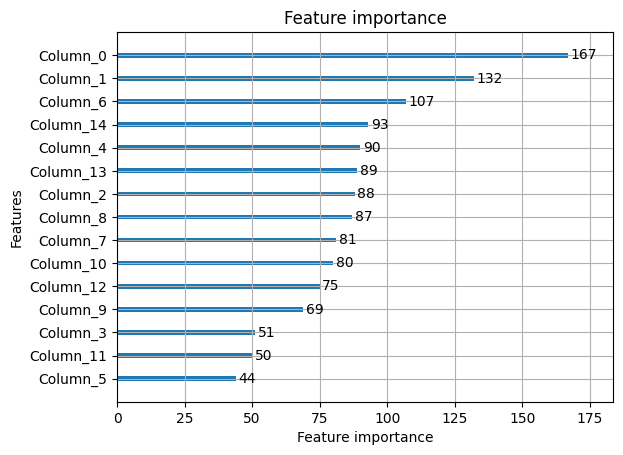

In [2775]:
lgb.plot_importance(lgbm_fe_tuned)

### LGB Backtest (with Tuning)

In [2776]:
N_TRAIN = split_idx

def get_X(data):
        """
        Method assumes that columns for independent variables X are all columns of
        the dataframe excluding the last column of the dataframe.
        """
        return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    """
    Method assumes that column for dependent variable y is the last column
    of the dataframe.
    """
    return data.filter(like="y_") # dependent variable has a prefix y_

class LGBStrategy(Strategy):
    price_delta = .004  # 0.4%
    
    def init(self):
        self.clf = lgbm_fe_tuned
        
        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return
    
        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        X = pca_15.transform(pd.DataFrame(scaler.transform(get_X(self.data.df.iloc[-1:])), columns=get_X(self.data.df.iloc[-1:]).columns))

        forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
    
        # if forecast != 1: 
        #     print(self.data.df.index[-1], forecast)
        if forecast == 2 and not self.position.is_long:
            self.buy(size=1)
        elif forecast == 0 and self.position.is_long:
            self.sell(size=1)

bt_pca_tuned = Backtest(backtest_data.copy(), LGBStrategy, cash=100000, commission=.0002, margin=0.05)
bt_pca_tuned.run()

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   14.635905
Equity Final [$]                  99822.93662
Equity Peak [$]                  136769.44436
Return [%]                          -0.177063
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                   -0.023316
Volatility (Ann.) [%]                8.819954
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -27.966047
Avg. Drawdown [%]                   -2.830335
Max. Drawdown Duration      442 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                   15
Win Rate [%]                        46.666667
Best Trade [%]                     214.749427
Worst Trade [%]                    -25.745771
Avg. Trade [%]                    

In [2777]:
bt_pca_tuned.plot()

Row(id='115096', ...)

### Case Based Reasoner (PCA data)

### PCA: Case Based Reasoner (3 clusters)

In [2778]:
# Initialize Case Based Reasoner
cbr = CaseBasedReasoningAgent(standard_data_scaled.iloc[:split_idx,:].copy(), scaler, 3)
cbr.train_model()

In [2779]:
N_TRAIN = split_idx

def get_X(data):
    return data.filter(like="X_") # all features are labelled with a prefix X_
    
def get_y(data):
    return data.filter(like="y_") # dependent variable has a prefix y_

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def rsi_signal(val, lower, upper):
        if val > upper:
            return False
        elif val < lower:
            return True
        else:
            return None
    
def ma_signal(price, ma_val):
    if price > ma_val:
        return True
    elif price < ma_val:
        return False
    else:
        return None

def ema_signal(price, ema_val):
    if price > ema_val:
        return True
    elif price < ema_val:
        return False
    else:
        return None

def aggregate_signals(aggregated_signals, predictions):
    output_signal = 0
    for i in ['RSI', 'MA', 'EMA']:
        signal_strength = aggregated_signals[i + "_correct"] / (aggregated_signals[i + "_correct"] + aggregated_signals[i + "_wrong"])
        indicator_value = 0
        if predictions[i] == True:
            indicator_value = 1
        elif predictions[i] == False:
            indicator_value = -1
        output_signal += signal_strength * indicator_value
    return output_signal
    
class CBRStrategy(Strategy):
    price_delta = .004  # 0.4%
    rsi_lower = 30
    rsi_upper = 70
            
    def init(self):
        self.clf = cbr
        
        self.features = backtest_data.drop(backtest_data.iloc[:,:], axis = 1)
        self.features['RSI_wrong'] = 0
        self.features['RSI_correct'] = 0
        self.features['MA_wrong'] = 0
        self.features['MA_correct'] = 0
        self.features['EMA_wrong'] = 0
        self.features['EMA_correct'] = 0
        # self.features['MOM_wrong'] = 0
        # self.features['MOM_correct'] = 0
        
        self.predictions = {
            "RSI": None,
            "MA": None,
            "EMA": None,
        }
        # index 0 -> wrong prediction
        # index 1 -> correct prediction

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')
        self.rsi30 = self.I(RSI, self.data.Close, 30)
        self.rsi100 = self.I(RSI, self.data.Close, 100)
        self.ma30 = self.I(MA, self.data.df, 'Close', 30)
        self.ma100 = self.I(MA, self.data.df, 'Close', 100)
        self.ema30 = self.I(EMA, self.data.df, 'Close', 30)
        self.ema100 = self.I(EMA, self.data.df, 'Close', 100)
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            # do prediction logic here
            if len(self.data) < 30:
                return

            def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
                if signal == None:
                    return True if y_true == HOLD else False
                else:
                    if signal == True:
                        return True if y_true == BUY else False
                    else:
                        return True if y_true == SELL else False

            current_idx = self.data.df.index[-1]
            for i in ['RSI', 'MA', 'EMA']:
                if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                    self.features.loc[current_idx, [i + "_correct"]] = 1
                else:
                    self.features.loc[current_idx, [i + "_wrong"]] = 1
            
            X = get_X(self.data.df.iloc[-1:])
            clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))
            
            rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
            ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
            ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])
      
            self.predictions['RSI'] = rsi_pred
            self.predictions['MA'] = ma_pred
            self.predictions['EMA'] = ema_pred
            
            signal_aggregation = {}
            for index, row in clusters.iterrows():
                feature_row = self.features.loc[index]
                signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
                signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
                signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
                signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
                signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
                signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
            return
        
        def is_signal_correct(signal, y_true, BUY=2, SELL=0, HOLD=1):
            if signal == None:
                return True if y_true == HOLD else False
            else:
                if signal == True:
                    return True if y_true == BUY else False
                else:
                    return True if y_true == SELL else False
        
        current_idx = self.data.df.index[-1]
        for i in ['RSI', 'MA', 'EMA']:
            # print(get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1'])
            if is_signal_correct(self.predictions[i], get_y(self.data.df.iloc[-1:]).iloc[0]['y_Close_t+1']):
                self.features.loc[current_idx, [i + "_correct"]] = 1
            else:
                self.features.loc[current_idx, [i + "_wrong"]] = 1
        
        X = get_X(self.data.df.iloc[-1:])
        # print(X)
        # transformed_input = self.clf._scaler.transform(X.values.reshape(1,-1))
        clusters = cbr.get_related_epochs(pd.DataFrame(X.values.reshape(1,-1), columns=X.columns))

        rsi_pred = rsi_signal(self.rsi30[-1], self.rsi_lower, self.rsi_upper)
        ma_pred = ma_signal(self.data.Close[-1], self.ma30[-1])
        ema_pred = ema_signal(self.data.Close[-1], self.ema30[-1])

        self.predictions['RSI'] = rsi_pred
        self.predictions['MA'] = ma_pred
        self.predictions['EMA'] = ema_pred      
        
        signal_aggregation = {}
        for index, row in clusters.iterrows():
            feature_row = self.features.loc[index]
            signal_aggregation['RSI_correct'] = signal_aggregation.get("RSI_correct", 0) + feature_row['RSI_correct']
            signal_aggregation['RSI_wrong'] = signal_aggregation.get("RSI_wrong", 0) + feature_row['RSI_wrong']
            signal_aggregation['MA_correct'] = signal_aggregation.get("MA_correct", 0) + feature_row['MA_correct']
            signal_aggregation['MA_wrong'] = signal_aggregation.get("MA_wrong", 0) + feature_row['MA_wrong']
            signal_aggregation['EMA_correct'] = signal_aggregation.get("EMA_correct", 0) + feature_row['EMA_correct']
            signal_aggregation['EMA_wrong'] = signal_aggregation.get("EMA_wrong", 0) + feature_row['EMA_wrong']
        
        # print(signal_aggregation)
        forecast = aggregate_signals(signal_aggregation, self.predictions)
#         forecast = self.clf.predict(X)[0]
        
        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        # print(forecast)
        
        if forecast > 0 and not self.position.is_long:
            self.buy(size=1)
        elif forecast < 0 and self.position.is_long:
            self.sell(size=1)

bt_fe_cbr_3 = Backtest(backtest_data.copy(), CBRStrategy, cash=100000, commission=.0002, margin=0.5)
stats_fe_cbr_3 = bt_fe_cbr_3.run()
# stats

KeyError: 3

In [ ]:
bt_fe_cbr_3.plot()

In [2523]:
stats_fe_cbr_3

Start                     2014-11-25 00:00:00
End                       2022-06-29 00:00:00
Duration                   2773 days 00:00:00
Exposure Time [%]                   17.555876
Equity Final [$]                 134633.39368
Equity Peak [$]                   147926.1392
Return [%]                          34.633394
Buy & Hold Return [%]             5242.074468
Return (Ann.) [%]                    3.990529
Volatility (Ann.) [%]                8.568043
Sharpe Ratio                         0.465746
Sortino Ratio                        0.707537
Calmar Ratio                         0.237605
Max. Drawdown [%]                  -16.794826
Avg. Drawdown [%]                   -2.215689
Max. Drawdown Duration      240 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                   37
Win Rate [%]                        27.027027
Best Trade [%]                     181.985151
Worst Trade [%]                    -12.795237
Avg. Trade [%]                    